## Visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Tuple, Optional
from dataclasses import dataclass
from enum import Enum
from matplotlib.animation import FuncAnimation


@dataclass
class MatplotlibVizConfig:
    # config for scientific visualization with matplotlib and save as svg
    figsize: Tuple[int, int] = (10, 10)
    dpi: int = 100
    background_color: str = "white"
    font_size: int = 20
    font_family: str = "Arial"
    font_color: str = "black"
    linewidth: int = 2  
    show_grid: bool = True
    use_tex: bool = True
    legend_loc: str = "upper right"
    title: str = ""
    hide_empty_plots: bool = True

    


class PlotOn(Enum):
    APPEND_RIGHT = "append_right"
    APPEND_DOWN = "append_down"
    RIGHT = "right"


class PlotType(Enum):
    LINE = "line"
    SCATTER = "scatter"
    BAR = "bar"
    HIST = "hist"
    IMAGE = "image"


@dataclass
class Plot:
    X: np.ndarray
    y: Optional[np.ndarray]
    plot_type: PlotType
    plot_order: PlotOn
    plot_row_col: Tuple[int, int] = (-1, -1)
    title: str = ""
    title_size: int = 7
    xlabel: str = ""
    ylabel: str = ""
    label_size: int = 10
    color: str = "blue"
    marker: Optional[str] = None
    linestyle: str = "-"
    linewidth: int = 2
    legend: Optional[str] = "_nolegend_"
    show_legend: bool = True
    legend_size: int = 7
    apply_margin: bool = False
    top_margin: float = 0.9
    bottom_margin: float = 0.1
    left_margin: float = 0.1
    right_margin: float = 0.9
    xmax: Optional[float] = None
    xmin: Optional[float] = None
    ymax: Optional[float] = None
    ymin: Optional[float] = None
    allow_animation: bool = True
    



class MatplotlibVisualizer:
    def __init__(self, config: MatplotlibVizConfig):
        self.config = config
        self._plots = []
        self.curr_row = 0
        self.curr_col = 0
        self.num_rows=1
        self.num_cols=1
        self.num_plots = 0
        self.ax_lim = {}
        self.completed_frames = []

    def make_figure(self):
        print(f"Making figure with {self.num_rows} rows and {self.num_cols} columns.")        
        fig, ax = plt.subplots(
            self.num_rows,
            self.num_cols,
            figsize=self.config.figsize,
            dpi=self.config.dpi,
            facecolor=self.config.background_color,
            
        )
        fig.suptitle(self.config.title, fontsize=self.config.font_size, fontfamily=self.config.font_family, color=self.config.font_color)
        plt.tight_layout()
        # use latex on text
        if self.config.use_tex:
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
        return fig, np.array(ax).reshape(self.num_rows, self.num_cols)

    def append_plot(
        self,
        plot: Plot,
        left_to_right: bool = True,
    ):
        if self.num_plots == 0:
            self.num_plots += 1
        else:
            if plot.plot_order == PlotOn.APPEND_RIGHT:
                if left_to_right:
                    self.curr_col += 1
            elif plot.plot_order == PlotOn.APPEND_DOWN:
                self.curr_row += 1
                if left_to_right:
                    self.curr_col = 0
            elif plot.plot_order == PlotOn.RIGHT:
                pass
            else:
                raise ValueError("Invalid plot order.")
            self.num_plots += 1
            self.num_rows = max(self.num_rows, self.curr_row + 1)
            self.num_cols = max(self.num_cols, self.curr_col + 1)

        
            
        plot.plot_row_col = (self.curr_row, self.curr_col)

        if plot.X is not None:
            if plot.xmax is None:
                plot.xmax = np.nanmax(plot.X)
            if plot.xmin is None:
                plot.xmin = np.nanmin(plot.X)
            if plot.plot_type == PlotType.IMAGE:
                plot.xmax = plot.X.shape[1]
                plot.xmin = 0
        if plot.y is not None:
            if plot.ymax is None:
                plot.ymax = np.nanmax(plot.y)
            if plot.ymin is None:
                plot.ymin = np.nanmin(plot.y)
        
        self._plots.append(plot)

    def _generate_plot(self, plot: Plot, ax, limit:int=-1):
        curr_row, curr_col = plot.plot_row_col
        key =f'{curr_row}_{curr_col}'
        label = plot.legend
        # print(f"Shape of X: {plot.X.shape}, Limit: {limit}, Label: {label}.")
        if plot.plot_type == PlotType.LINE:
            ax.plot(plot.X[:limit], plot.y[:limit], color=plot.color, marker=plot.marker, linestyle=plot.linestyle, linewidth=plot.linewidth, label=label)
        elif plot.plot_type == PlotType.SCATTER:
            ax.scatter(plot.X[:limit], plot.y[:limit], color=plot.color, marker=plot.marker, linewidth=plot.linewidth, label=label)
        elif plot.plot_type == PlotType.BAR:
            ax.bar(plot.X[:limit], plot.y[:limit], color=plot.color, label=label)
        elif plot.plot_type == PlotType.HIST:
            ax.hist(plot.X[:limit], color=plot.color, label=label)
        elif plot.plot_type == PlotType.IMAGE:
            ax.imshow(plot.X)
        else:
            raise ValueError("Invalid plot type.")

        
        # add left margin
        # print(ax.get_xlim(), ax.get_ylim())
        x_min, x_max = plot.xmin, plot.xmax #ax.get_xlim()
        y_min, y_max = plot.ymin, plot.ymax #ax.get_ylim()
        
        if self.ax_lim.get(key) is None:
            self.ax_lim[key] = []
        else:
            # print(f"Existing limits: {self.ax_lim[key]}, keys: {key}")
            x_min = min(x_min, self.ax_lim[key][0]) if (self.ax_lim[key][0] is not None and x_max is not None) else ax.get_xlim()[0]
            x_max = max(x_max, self.ax_lim[key][1]) if (self.ax_lim[key][1] is not None and x_max is not None) else ax.get_xlim()[1]
            y_min = min(y_min, self.ax_lim[key][2]) if (self.ax_lim[key][2] is not None and y_min is not None) else ax.get_ylim()[0]
            y_max = max(y_max, self.ax_lim[key][3]) if (self.ax_lim[key][3] is not None and y_max is not None) else ax.get_ylim()[1]
        self.ax_lim[key]=[x_min, x_max, y_min, y_max]

        if plot.apply_margin:
            ax.set_xlim([x_min - plot.left_margin, x_max + plot.right_margin])
            if plot.y is not None:
                ax.set_ylim([y_min - plot.bottom_margin, y_max + plot.top_margin])
        
        ax.set_title(plot.title, fontsize=plot.title_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.set_xlabel(plot.xlabel, fontsize=plot.label_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.set_ylabel(plot.ylabel, fontsize=plot.label_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.grid(self.config.show_grid)
        
        return ax

    def generate_plots(self, save_path: Optional[Path] = None, format: str = "svg"):        
        # get figure and axes
        fig, ax = self.make_figure()
               
        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col     
            curr_ax = ax[curr_row, curr_col]
            
            curr_ax = self._generate_plot(plot, curr_ax, limit=plot.X.shape[0])
        
        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col 
            curr_ax = ax[curr_row, curr_col]
            if plot.show_legend:
                curr_ax.legend(loc=self.config.legend_loc, fontsize=plot.legend_size)
        
        # hide empty plots
        if self.config.hide_empty_plots:
            plot_row_col = [plot.plot_row_col for plot in self._plots]
            for i in range(self.num_rows):
                for j in range(self.num_cols):
                    if (i, j) not in plot_row_col:
                        ax[i, j].axis("off")
        
        if save_path is not None:
            self.save_fig(fig, save_path, format=format)


        return fig, ax

    def _animate(self, curr_frame, ax, num_frames=30):
        curr_frame+=1
        print(f"Animating frame {curr_frame}. Completed frames: {self.completed_frames}. Num frames: {num_frames}.")
        
        for plot in self._plots:
            anim_plot = True
            curr_row, curr_col = plot.plot_row_col
            curr_ax = ax[curr_row, curr_col]
            if curr_frame>1 or curr_frame in self.completed_frames:
                plot.legend = '_nolegend_'
            
            if plot.allow_animation:
                limit = int((curr_frame+1) * len(plot.X) / num_frames)
            else:
                if curr_frame==1:            
                    limit = len(plot.X)
                else:
                    anim_plot = False
            if anim_plot:
                curr_ax = self._generate_plot(plot, curr_ax, limit=limit)
        self.completed_frames.append(curr_frame)
            
        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col 
            curr_ax = ax[curr_row, curr_col]
            if plot.show_legend:
                curr_ax.legend(loc=self.config.legend_loc, fontsize=plot.legend_size)
            
        # hide empty plots
        if self.config.hide_empty_plots:
            plot_row_col = [plot.plot_row_col for plot in self._plots]
            for i in range(self.num_rows):
                for j in range(self.num_cols):
                    if (i, j) not in plot_row_col:
                        ax[i, j].axis("off")
        
        return ax
    
    def animate_plots(self, interval: int = 10, frames: int = 10, save_path: Optional[Path] = None):
        fig, ax = self.make_figure()
        anim = FuncAnimation(fig, self._animate, frames=frames, fargs=(ax, frames,), interval=interval)
        if save_path is not None:
            self.save_animation(anim, save_path)
        return anim
    
    def save_animation(self, anim, path: Path):
        anim.save(path)

    def save_fig(self, fig, path: Path, format: str = "svg"):
        fig.savefig(path, format=format, dpi=self.config.dpi)

    def show_fig(self):
        plt.show()

    def close_fig(self, fig):
        plt.close(fig)
    
    def clear_plots(self):
        self._plots = []
        self.num_plots = 0
        self.curr_row = 0
        self.curr_col = 0
        self.num_rows=1
        self.num_cols=1
        plt.clf()
    

Making figure with 3 rows and 2 columns.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


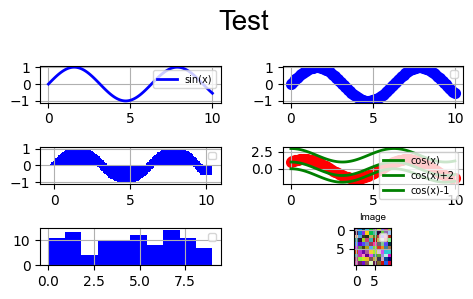

In [2]:
viz_config = MatplotlibVizConfig(figsize=(5,3),title="Test",
                                 use_tex=False,)
viz = MatplotlibVisualizer(config=viz_config)

X = np.linspace(0, 10, 110)
y = np.sin(X)
z = np.cos(X)
w = y+z

# show legend in latex format

plot1 = Plot(X=X, y=y, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="sin(x)")
plot2 = Plot(X=X, y=y, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT)
plot3 = Plot(X=X, y=y, plot_type=PlotType.BAR, plot_order=PlotOn.APPEND_DOWN)
plot4 = Plot(X=X, y=z, plot_type=PlotType.LINE, plot_order=PlotOn.APPEND_RIGHT, legend="cos(x)", color="green", allow_animation=False)
plot41 = Plot(X=X, y=z+2, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="cos(x)+2", color="green", allow_animation=False)
plot42 = Plot(X=X, y=z-1, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="cos(x)-1", color="green", allow_animation=False)
plot5 = Plot(X=X, y=w, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend="sin(x)+cos(x)", color="red")
plot5 = Plot(X=X, y=w, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, color="red", allow_animation=False)

plot6 = Plot(X=np.random.randint(0, 10, 100), y=None, plot_type=PlotType.HIST, plot_order=PlotOn.APPEND_DOWN)
plot7 = Plot(X=np.random.randint(0, 255,(10,10, 3)), y=None, plot_type=PlotType.IMAGE, plot_order=PlotOn.APPEND_RIGHT, title="Image")


viz.append_plot(plot1)
viz.append_plot(plot2)
viz.append_plot(plot3)
viz.append_plot(plot4)
viz.append_plot(plot41)
viz.append_plot(plot42)
viz.append_plot(plot5)
viz.append_plot(plot6)
viz.append_plot(plot7)


fig, ax = viz.generate_plots()
viz.save_fig(fig, Path("expt_res/test.png"), 'png')
viz.show_fig()
# viz.close_fig(fig)
# print(ax)

MovieWriter imagemagick unavailable; using Pillow instead.


Making figure with 3 rows and 2 columns.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Animating frame 1. Completed frames: []. Num frames: 10.
Animating frame 1. Completed frames: [1]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 2. Completed frames: [1, 1]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 3. Completed frames: [1, 1, 2]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 4. Completed frames: [1, 1, 2, 3]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 5. Completed frames: [1, 1, 2, 3, 4]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 6. Completed frames: [1, 1, 2, 3, 4, 5]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 7. Completed frames: [1, 1, 2, 3, 4, 5, 6]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 8. Completed frames: [1, 1, 2, 3, 4, 5, 6, 7]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 9. Completed frames: [1, 1, 2, 3, 4, 5, 6, 7, 8]. Num frames: 10.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animating frame 10. Completed frames: [1, 1, 2, 3, 4, 5, 6, 7, 8, 9]. Num frames: 10.


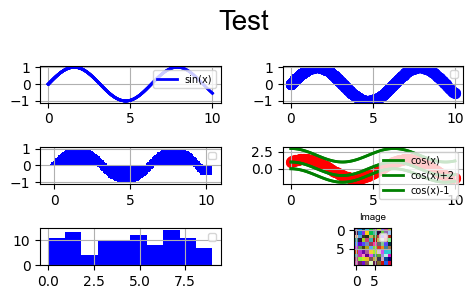

In [3]:
viz.animate_plots(interval=90,frames=10).save('expt_res/test.gif', writer='imagemagick', fps=30)

## Loss

In [4]:
from enum import Enum
import numpy as np


class LossType(Enum):
    MSE = "mean_squared_error"
    MAE = "mean_absolute_error"
    HINGE = "hinge"
    RMSE = "root_mean_squared_error"


class Loss:
    def __init__(self, loss_type: LossType):
        self.loss_type = loss_type
        self.name = loss_type.value

    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.loss_type == LossType.MSE:
            return self.mean_squared_error(y_true, y_pred)
        elif self.loss_type == LossType.MAE:
            return self.mean_absolute_error(y_true, y_pred)
        elif self.loss_type == LossType.HINGE:
            return self.hinge(y_true, y_pred)
        elif self.loss_type == LossType.RMSE:
            return self.mean_squared_error(y_true, y_pred)**0.5
        else:
            raise ValueError(f"Loss type {self.loss_type} not supported")

    def mean_squared_error(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return ((y_true - y_pred) ** 2).mean()

    def mean_absolute_error(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (y_true - y_pred).abs().mean()

    def hinge(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (1 - y_true * y_pred).clip(min=0).mean()


## Data Generator

In [5]:
from typing import Union
import torch
from torch.utils.data import Dataset

@dataclass
class DataGeneratorConfig:
    num_rows: int
    num_cols: int
    min_val: int = 0
    max_val: int = 100
    seed: int = 100
    normalize: bool = True
    noise: Union[float, np.ndarray] = 0.0
    weights: Optional[np.ndarray] = None
    biases: Optional[np.ndarray] = None



class DataGenerator:
    def __init__(self, config: DataGeneratorConfig):
        self.config = config

        np.random.seed(self.config.seed)
        self.X = np.random.uniform(self.config.min_val, self.config.max_val+1, (self.config.num_rows, self.config.num_cols))
        self.normalize = self.config.normalize
        if self.config.normalize:
            self.X = self.X/np.max(self.X)
        self.weights = self.config.weights
        self.biases = self.config.biases
        self.noise = self.config.noise if self.config.noise is not None else np.random.randn(self.config.num_rows)

    def make_data(self):
        if self.weights is None:
            self.weights = np.random.randn(self.X.shape[1])
        if self.biases is None:
            self.biases = np.random.randn(1)        

        self.y = np.dot(self.X, self.weights) + self.biases + self.noise
        self.X, self.y = torch.tensor(self.X, dtype=torch.float32), torch.tensor(self.y, dtype=torch.float32)
        return self.X, self.y

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            raise ValueError("No y values found. Please generate data first.")
        return self.X[idx], self.y[idx]

## make sure the data is generated correctly
data_gen1 = DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=20))
data_gen1.make_data()

data_gen2 = DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=20))
data_gen2.make_data()
data_gen2.weights == data_gen1.weights, data_gen2.biases == data_gen1.biases

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]),
 array([ True]))

## Experiment

In [6]:
import torch.nn as nn
from typing import List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
from dataclasses import asdict, field
from typing import Union, Optional

from gradls.vis.colors import visible_colors

class Optimizer(Enum):
    SGD = "sgd"
    ADAM = "adam"
    RMSPROP = "rmsprop"
    ADAGRAD = "adagrad"
    ADADELTA = "adadelta"
    ADAMAX = "adamax"
    ADAMW = "adamw"


@dataclass
class ExperimentConfig:
    name: str
    viz_config: MatplotlibVizConfig
    num_epochs:int
    batch_size:int
    loss:LossType
    model:Optional[nn.Module]=None
    optimizer:Optimizer=Optimizer.SGD
    learning_rate:float=0.01
    momentum:float=0.0
    train_valid_split:float=0.1
    seed:Optional[int]=100
    metrics:List[LossType]=field(default_factory=lambda:[LossType.MAE])
    log_every:int=1
    log_dir:Path=None
    log_anim:bool=True
    log_plots:bool=True
    plot_format:str='png'
    anim_interval:int=100 
    anim_frames:int=10
    anim_fps:int=30
    log_real_params:bool=True
    log_real_data:bool=True

class Runner:
    def __init__(self, name:str, model:nn.Module, batch_size:int, optimizer:str, loss:Loss, 
                 metrics:Optional[List[Loss]]=[], log_every:int=1, log_params:bool=False,
                 is_test:bool=False, data:Dataset=None, l1_penalty:float=0.0, l2_penalty:float=0.0):
        self.name = name
        self.batch_size = batch_size
        self.metrics = metrics
        self.loss = loss
        self.optimizer = optimizer
        self.model = model
        self.is_test = is_test
        self.data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
        self.logs = {metric.name:[] for metric in self.metrics}
        self.logs[f"{name}_loss({loss.name})"] = []
        self.curr_epoch = 0
        self.log_every = log_every
        self.log_params = log_params
        self.logs['epochs']=[]
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
        if log_params:
            self.logs['weights']=[]
            self.logs['biases']=[]
            self.logs['weight_gradients']=[]
            self.logs['bias_gradients']=[]
            self.logs['learning_rate']=[]
        
    
    def step(self):
        if self.is_test:
            self.model.eval()
        else:
            self.model.train()
        
        batch_losses = []
        batch_metrics = {metric.name:[] for metric in self.metrics}
        # print(self.metrics)
        
        # all_preds = []

        for i, (X, y) in enumerate(self.data_loader):
            # print(X.shape, y.shape)            
            y_pred = self.model(X)
            
            # if self.log_output:
            #     all_preds.extend(y_pred.detach().numpy().tolist())

            loss = self.loss(y, y_pred.squeeze())
            batch_losses.append(loss.item())

            params = torch.cat([p.view(-1) for p in self.model.parameters()])
            # print(loss)
            
            if self.l1_penalty > 0:
                loss += self.l1_penalty * torch.abs(params).sum()
            if self.l2_penalty > 0:
                loss += self.l2_penalty * (params**2).sum()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            for metric in self.metrics:
                batch_metrics[metric.name].append(metric(y, y_pred).detach().numpy())

        if self.curr_epoch % self.log_every == 0:    
            epoch_loss = np.mean(batch_losses)
            epoch_metrics = {metric.name:np.mean(batch_metrics[metric.name]) for metric in self.metrics}
            self.logs[f"{self.name}_loss({self.loss.name})"].append(epoch_loss)
            for metric in self.metrics:
                self.logs[metric.name].append(epoch_metrics[metric.name])
            
            self.logs['epochs'].append(self.curr_epoch)

            if self.log_params:
                self.logs['weights'].append(self.model.weight.data.numpy().copy())
                self.logs['biases'].append(self.model.bias.data.numpy().copy())
                self.logs['weight_gradients'].append(self.model.weight.grad.data.numpy().copy())
                self.logs['bias_gradients'].append(self.model.bias.grad.data.numpy().copy())
                self.logs['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
        self.curr_epoch += 1

        # if self.log_output:
        #     self.predictions.append(all_preds)

        return epoch_loss, epoch_metrics


class Experiment:
    def __init__(self, config: ExperimentConfig):
        if config.seed is None:
            config.seed = np.random.randint(0, 100) 
        torch.manual_seed(config.seed)
        self.config = config
        self.viz_config = config.viz_config
        self.viz = MatplotlibVisualizer(config=self.viz_config)
        self.losses = {}
        self.metrics = {metric.value:[] for metric in self.config.metrics}
        self.optimizer = None
        self.real_weights = None
        self.real_biases = None
        
        self.loss_fxn = Loss(self.config.loss)       
        
    
    def load_data(self, data:DataGenerator):
        self.data_config = data.config
        self.data = data
        X, y = data.make_data()
        self.real_weights = data.weights
        self.real_biases = data.biases
                
        if self.config.model is None:
            self.config.model = nn.Linear(in_features=X.shape[1], out_features=1)

        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=self.config.train_valid_split, random_state=self.config.seed)
        self.train_X, self.val_X, self.train_y, self.val_y = train_X, val_X, train_y, val_y
        self.make_runners()
    
    def make_runners(self):
        train_data = MyDataset(self.train_X, self.train_y)
        val_data = MyDataset(self.val_X, self.val_y)

        if self.config.optimizer == Optimizer.SGD:
            self.optimizer = torch.optim.SGD(self.config.model.parameters(), lr=self.config.learning_rate, momentum=self.config.momentum)
        elif self.config.optimizer == Optimizer.ADAM:
            self.optimizer = torch.optim.Adam(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.RMSPROP:
            self.optimizer = torch.optim.RMSprop(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADAGRAD:
            self.optimizer = torch.optim.Adagrad(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADADELTA:
            self.optimizer = torch.optim.Adadelta(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADAMAX:
            self.optimizer = torch.optim.Adamax(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADAMW:
            self.optimizer = torch.optim.AdamW(self.config.model.parameters(), lr=self.config.learning_rate)
        else:
            raise ValueError("Invalid optimizer type.")

        if self.config.batch_size < 1:
            train_batch_size = len(train_data)
            test_batch_size = len(val_data)
        else:
            train_batch_size = self.config.batch_size
            test_batch_size = self.config.batch_size
            
        self.train_runner = Runner(name="train",loss=self.loss_fxn, model=self.config.model, batch_size=train_batch_size, optimizer=self.optimizer, 
                                   metrics=[Loss(m) for m in self.config.metrics], data=train_data, log_params=True)
        self.val_runner = Runner(name="val", loss=self.loss_fxn,model=self.config.model, batch_size=test_batch_size, optimizer=self.optimizer, 
                                 metrics=[Loss(m) for m in self.config.metrics], is_test=True, data=val_data)
    

    def train(self):
        for epoch in range(self.config.num_epochs):
            train_loss, train_metrics = self.train_runner.step()
            val_loss, val_metrics = self.val_runner.step()
            self.losses[epoch] = {"train_loss":train_loss, "val_loss":val_loss}
            for metric in self.config.metrics:
                self.metrics[metric.value].append({"train":train_metrics[metric.value], "val":val_metrics[metric.value]})
            
            # train_mse, val_mse, train_bias, val_bias, train_variance, val_variance = self.calculate_bias_variance()

            if epoch % self.config.log_every == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss}, Val Loss: {val_loss}")
            

        print("Training complete.")
            
    def get_default_plots(self, plot_parameters:bool=True)->List[Plot]:
        plots = []
        colors = visible_colors
        keys = list(colors.values())
        # np.random.shuffle(keys)
        train_loss = np.array([m["train_loss"] for m in self.losses.values()])
        val_loss = np.array([m["val_loss"] for m in self.losses.values()])
        plots.append(Plot(X=np.arange(self.config.num_epochs), y=train_loss, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="train_loss", color=keys[0]))
        plots.append(Plot(X=np.arange(self.config.num_epochs), y=val_loss, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="val_loss", color=keys[1]))

        for metric in self.config.metrics:
            train_metric = np.array([m["train"] for m in self.metrics[metric.value]])
            val_metric = np.array([m["val"] for m in self.metrics[metric.value]])
            
            plots.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=PlotOn.APPEND_RIGHT, legend=f"train_{metric.value}", color=keys[2]))
            plots.append(Plot(X=np.arange(len(val_metric)), y=val_metric, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend=f"val_{metric.value}", color=keys[3]))

        if plot_parameters and self.train_runner.log_params:
            epochs = np.array(self.train_runner.logs['epochs'])
            weights = np.array(self.train_runner.logs['weights']).reshape(len(epochs), -1)
            biases = np.array(self.train_runner.logs['biases']).reshape(len(epochs), -1)
            weight_gradients = np.array(self.train_runner.logs['weight_gradients']).reshape(len(epochs), -1)
            bias_gradients = np.array(self.train_runner.logs['bias_gradients']).reshape(len(epochs), -1)
            

            weights_plots = []
            biases_plots = []
            gradients_plots = []
            real_weights = self.real_weights
            
            for widx in range(weights.shape[1]):
                weight = weights[:, widx].flatten()
                weight_gradient = weight_gradients[:, widx].flatten()
                color = keys[len(colors)%(widx+1)]
                if widx == 0:
                    weights_plots.append(Plot(X=epochs, y=weight, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_DOWN, title='Weights', color=color))
                    
                    gradients_plots.append(Plot(X=epochs, y=weight_gradient, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT, title='Gradients', color=color))
                else:
                    weights_plots.append(Plot(X=epochs, y=weight, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, color=color, title='Weights', xlabel='Epoch'))
                    
                    gradients_plots.append(Plot(X=epochs, y=weight_gradient, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, color=color, xlabel='Epoch', title='Gradients'))

            bc=keys[len(colors)-1]
            weights_plots.extend([Plot(X=epochs, y=[b.flatten() for b in biases], plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x',
                                     title='Biases', xlabel='Epoch', color=bc, legend='Trained Bias'),
                                    #  Plot(X=epochs, y=[self.real_biases]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x', 
                                    #  title='Biases', xlabel='Epoch', legend='Real Bias', color=bc, allow_animation=False)
                                     ])
            gradients_plots.extend([Plot(X=epochs, y=[bg.flatten() for bg in bias_gradients], plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x',
                                     title='Biases', xlabel='Epoch', color=bc, legend='Bias Gradients'),
                                    #  Plot(X=epochs, y=[0]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x', 
                                    #  title='Biases', xlabel='Epoch', legend='Real Bias', color=bc, allow_animation=False)
                                     ])
            

            # if self.config.log_real_params:
            #     weights_plots[-1].legend='Real Weights'
            weights_plots[-2].legend='Trained Weights'
            weights_plots[-1].xlabel='Epoch'

            gradients_plots[-1].legend='Gradients'

            plots.extend(weights_plots)
            plots.extend(biases_plots)
            plots.extend(gradients_plots)
            if self.config.log_real_params:
                plots.extend([
                    Plot(X=np.arange(len(real_weights)), y=real_weights, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT, 
                                   title='Real Parameters', legend='Real Weights',color=keys[4], allow_animation=False), 
                            Plot(X=np.array([int(len(real_weights)//2)]), y=np.array([self.real_biases[0]]), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend='Real Bias', linewidth=10, 
                                 marker='+', color=keys[10], allow_animation=False)])
            

        print(f"Found {len(plots)} metrics to plot.")
        return plots    
    
        
    def animate_plots(self, interval: int = 10, frames: int = 10):
        return self.viz.animate_plots(interval, frames)
    
    def save_fig(self, fig, path: Path, format: str = "svg"):
        self.viz.save_fig(fig, path, format)
    
    def show_fig(self):
        self.viz.show_fig()
    
    def log_expt(self,  plots:Optional[List[Plot]]=None)->Path:       

        if self.config.log_dir is None:
            self.config.log_dir = Path("expt_res")
        expt_dir = Path(f"{self.config.log_dir}/{self.config.name}")
        expt_dir.mkdir(parents=True, exist_ok=True) 
        
        if self.config.log_plots:
            if plots is None:
                plots = self.get_default_plots()
            self.viz.clear_plots()
            for plot in plots:
                self.viz.append_plot(plot)
            fig, ax = self.viz.generate_plots()
            self.save_fig(fig, Path(f"{expt_dir}/{self.config.name}.{self.config.plot_format}"), format=self.config.plot_format)
        if self.config.log_anim:
            self.animate_plots(interval=self.config.anim_interval, frames=self.config.anim_frames).save(Path(f"{expt_dir}/{self.config.name}.gif"), 
                                                                                                        writer='imagemagick', fps=self.config.anim_fps)

        

        # log expt config
        expt_config = asdict(self.config)
        np.save(Path(f"{self.config.log_dir}/{self.config.name}/config.npy"), expt_config)

        print(f"Experiment results saved at {expt_dir}.")

        if self.config.log_real_data:
            # store train and val data as numpy files
            np.save(Path(f"{expt_dir}/train_X.npy"), self.train_X.numpy())
            np.save(Path(f"{expt_dir}/train_y.npy"), self.train_y.numpy())
            np.save(Path(f"{expt_dir}/val_X.npy"), self.val_X.numpy())
            np.save(Path(f"{expt_dir}/val_y.npy"), self.val_y.numpy())
            print("Data saved.")

        # store all logs from runners
        logs = {key:runner.logs for key, runner in zip(['train', 'val'], [self.train_runner, self.val_runner])}
        np.save(Path(f"{expt_dir}/logs.npy"), logs)
        print("Logs saved.")

        if self.config.log_real_params:
            # store real weights and biases
            np.save(Path(f"{expt_dir}/real_weights.npy"), self.real_weights)
            np.save(Path(f"{expt_dir}/real_biases.npy"), self.real_biases)
            print("Real weights and biases saved.")
        # store all params from model, no need its in experiment config
        # torch.save(self.config.model.state_dict(), Path(f"{expt_dir}/model.pth"))
        # print("Model saved.")

        # store all losses and metrics
        np.save(Path(f"{expt_dir}/losses.npy"), self.losses)
        np.save(Path(f"{expt_dir}/metrics.npy"), self.metrics)
        print("Losses and metrics saved.")
        return expt_dir


in_features = 20
out_features = 1
viz_config = MatplotlibVizConfig(figsize=(15,10),title="My Exp",
                                 use_tex=False)
exp_config = ExperimentConfig(name="Exp5", loss=LossType.MAE, viz_config=viz_config, 
                              num_epochs=10, batch_size=24,learning_rate=0.1, optimizer=Optimizer.ADAM,
                              model=None, metrics=[LossType.MSE, LossType.RMSE],
                              log_every=1, log_anim=False, anim_fps=10, plot_format='png')

data = DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=in_features, min_val=0, max_val=100, seed=100, normalize=True, noise=0.1))

exp = Experiment(config=exp_config)
exp.load_data(data)
exp.train()


Epoch 0: Train Loss: 0.9074198870282424, Val Loss: 0.39941601157188417
Epoch 1: Train Loss: 0.21802597581163832, Val Loss: 0.09186975210905075
Epoch 2: Train Loss: 0.07877798476501514, Val Loss: 0.09878912791609765
Epoch 3: Train Loss: 0.09786985760652706, Val Loss: 0.12409988567233085
Epoch 4: Train Loss: 0.05837835207287418, Val Loss: 0.035256413742899895
Epoch 5: Train Loss: 0.06363648195800028, Val Loss: 0.07778438255190849
Epoch 6: Train Loss: 0.05762955671372382, Val Loss: 0.08144571185112
Epoch 7: Train Loss: 0.06467246058347978, Val Loss: 0.17085629925131798
Epoch 8: Train Loss: 0.08506168376066182, Val Loss: 0.057304540276527406
Epoch 9: Train Loss: 0.05692537280877954, Val Loss: 0.06006221026182175
Training complete.


Found 50 metrics to plot.
Making figure with 2 rows and 3 columns.
Experiment results saved at expt_res\Exp5.
Data saved.
Logs saved.
Real weights and biases saved.
Losses and metrics saved.


WindowsPath('expt_res/Exp5')

<Figure size 640x480 with 0 Axes>

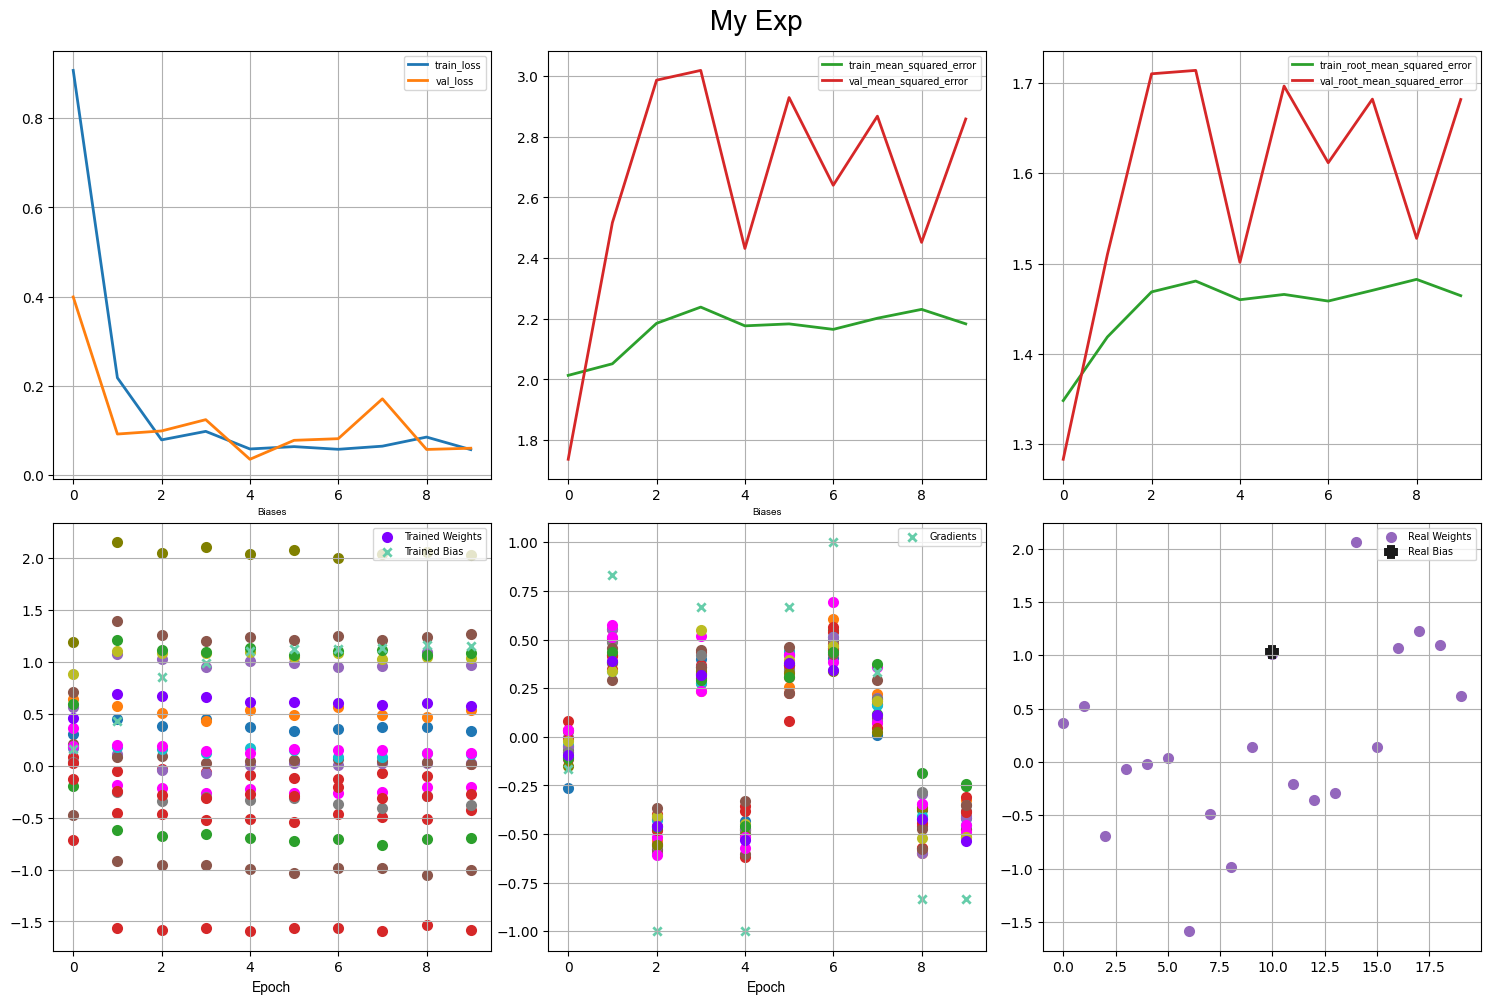

In [7]:
exp.log_expt()

## Experiment Handler

Possible combinations: 1 seeds, 1 data generators, 2 losses, 1 epochs, 3 batch sizes, 2 optimizers, 2 learning rates, 2 momentums.
Found 48 possible combinations.
Running experiment (Exp_100_mean_absolute_error_6_1_sgd_0.01_0.1) 1/48.
Epoch 0: Train Loss: 0.3358574255141947, Val Loss: 0.050704381316900256
Epoch 1: Train Loss: 0.015012058789013988, Val Loss: 0.01397896520793438
Epoch 2: Train Loss: 0.013273858503542013, Val Loss: 0.01383792594075203
Epoch 3: Train Loss: 0.013231918986679778, Val Loss: 0.01371484637260437
Epoch 4: Train Loss: 0.013286138717085123, Val Loss: 0.013750023692846298
Epoch 5: Train Loss: 0.013251382876704965, Val Loss: 0.013786413893103599
Training complete.
Found 16 metrics to plot.
Making figure with 2 rows and 2 columns.
Experiment results saved at expt_res\Exp_100_1000_5\Exp_100_mean_absolute_error_6_1_sgd_0.01_0.1.
Logs saved.
Losses and metrics saved.
Running experiment (Exp_100_mean_absolute_error_6_1_sgd_0.01_0.9) 2/48.


C:\Users\Viper\AppData\Local\Temp\ipykernel_11972\3841724386.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X, self.y = torch.tensor(self.X, dtype=torch.float32), torch.tensor(self.y, dtype=torch.float32)


Epoch 0: Train Loss: 0.10756463914592233, Val Loss: 0.03903278652578592
Epoch 1: Train Loss: 0.08004997658646769, Val Loss: 0.06529395036399364
Epoch 2: Train Loss: 0.06980727735492918, Val Loss: 0.0665042370557785
Epoch 3: Train Loss: 0.07229514530032045, Val Loss: 0.07073665991425514
Epoch 4: Train Loss: 0.07317799936980009, Val Loss: 0.09022944942116737
Epoch 5: Train Loss: 0.06837356244110399, Val Loss: 0.08575103268027305
Training complete.
Found 16 metrics to plot.
Making figure with 2 rows and 2 columns.
Experiment results saved at expt_res\Exp_100_1000_5\Exp_100_mean_absolute_error_6_1_sgd_0.01_0.9.
Logs saved.
Losses and metrics saved.
Running experiment (Exp_100_mean_absolute_error_6_1_sgd_0.1_0.1) 3/48.
Epoch 0: Train Loss: 0.16771099831908942, Val Loss: 0.13409483052790164
Epoch 1: Train Loss: 0.13273476394928163, Val Loss: 0.13582904025912285
Epoch 2: Train Loss: 0.1328363817738783, Val Loss: 0.1385719270259142
Epoch 3: Train Loss: 0.13382875792061288, Val Loss: 0.13959359

C:\Users\Viper\AppData\Local\Temp\ipykernel_11972\2290535131.py:90: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(


Experiment results saved at expt_res\Exp_100_1000_5\Exp_100_mean_squared_error_6_1_sgd_0.01_0.9.
Logs saved.
Losses and metrics saved.
Running experiment (Exp_100_mean_squared_error_6_1_sgd_0.1_0.1) 21/48.
Epoch 0: Train Loss: 0.02308941079210475, Val Loss: 4.234738975039676e-09
Epoch 1: Train Loss: 1.271666227432238e-10, Val Loss: 1.0925149673823853e-14
Epoch 2: Train Loss: 1.050385089056543e-14, Val Loss: 1.3594125825022729e-14
Epoch 3: Train Loss: 1.286618792373182e-14, Val Loss: 1.3584688929313415e-14
Epoch 4: Train Loss: 1.0475595618215195e-14, Val Loss: 1.5709655798445965e-14
Epoch 5: Train Loss: 1.0672907403181486e-14, Val Loss: 1.1926015730523432e-14
Training complete.
Found 16 metrics to plot.
Making figure with 2 rows and 2 columns.
Experiment results saved at expt_res\Exp_100_1000_5\Exp_100_mean_squared_error_6_1_sgd_0.1_0.1.
Logs saved.
Losses and metrics saved.
Running experiment (Exp_100_mean_squared_error_6_1_sgd_0.1_0.9) 22/48.
Epoch 0: Train Loss: 0.46434697995407015, 

<Figure size 640x480 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

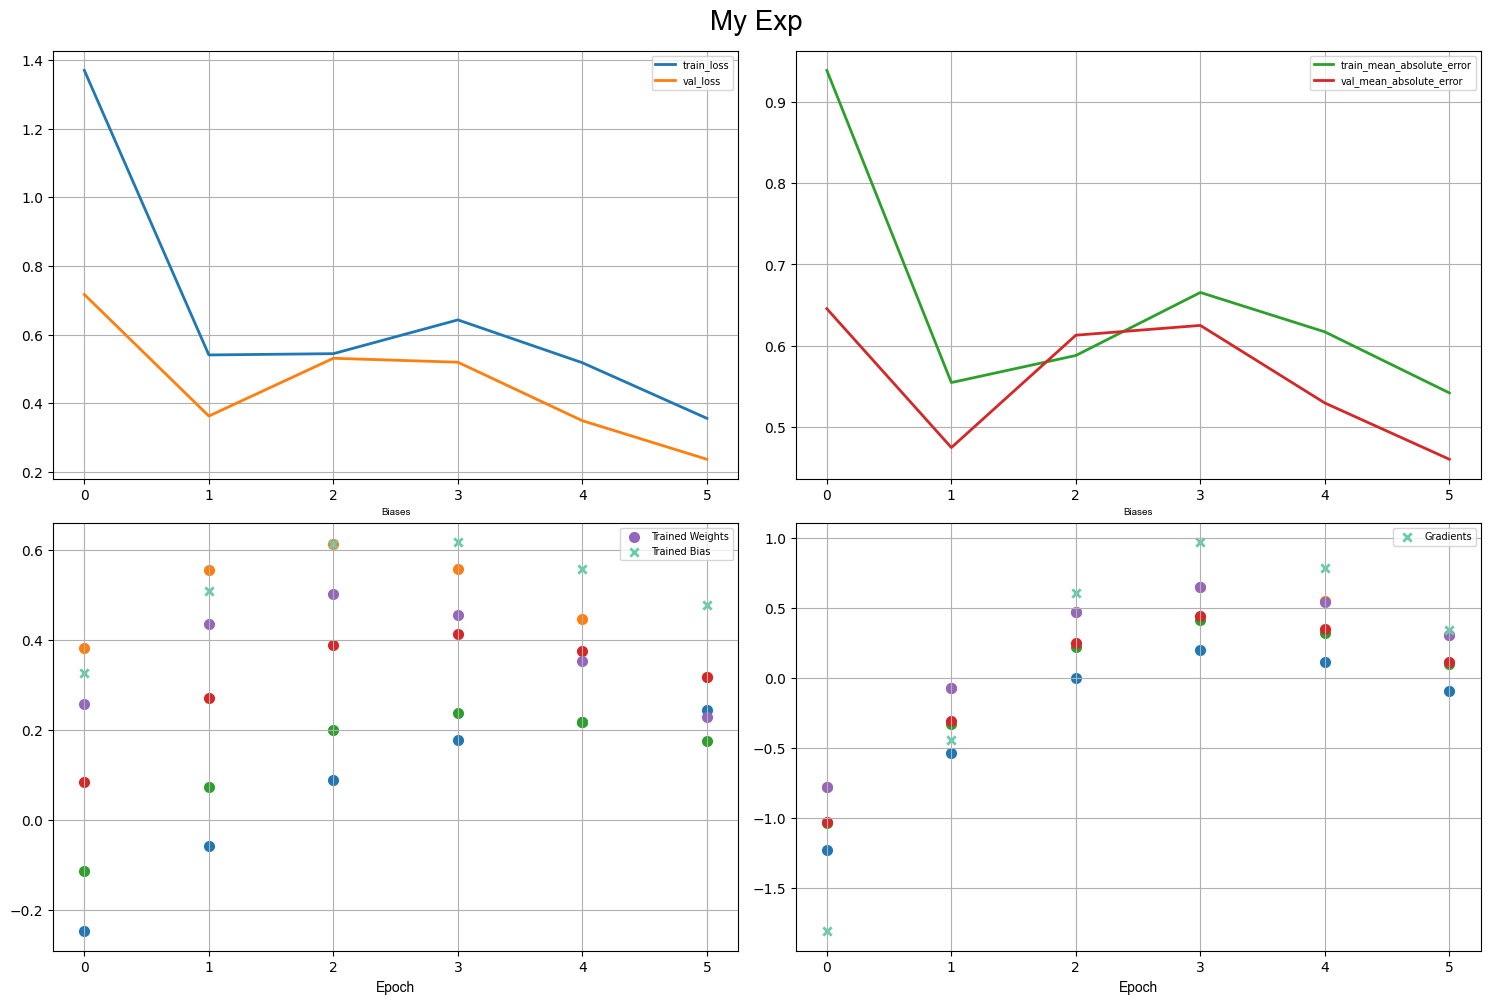

In [14]:
@dataclass
class ExperimentHandlerConfig:
    root_dir:Path
    data_gen: List[DataGenerator] = field(default_factory=lambda:[DataGenerator(num_rows=1000, num_cols=20, weights=None, biases=None, max_val=100, 
                     normalize=True, seed=100)])
    losses: List[LossType] = field(default_factory=lambda:[LossType.MAE])
    metrics: List[LossType] = field(default_factory=lambda:[LossType.MSE])
    num_epochs: List[int] = field(default_factory=lambda:[10])
    batch_sizes: List[int] = field(default_factory=lambda:[64])
    optimizers: List[Optimizer] = field(default_factory=lambda:[Optimizer.ADAM])
    seeds: List[int] = field(default_factory=lambda:[100])
    learning_rates: List[float] = field(default_factory=lambda:[0.1])
    momentums: List[float] = field(default_factory=lambda:[0.0])
    plot_format: str='png'
    log_anim: bool=True
    log_plots: bool=True
    log_real_params: bool=False
    log_real_data: bool=False
    train_test_split: List[float]=field(default_factory=lambda:[0.1])



class ExperimentHandler:
    def __init__(self, root_dir:Path, config:Optional[ExperimentHandlerConfig]=None, expt_names:Optional[List[str]]=None):
        self.config = config
        self.root_dir = root_dir if self.config is None else self.config.root_dir
        self.experiments = {}
        self.losses = {}
        self.metrics = {}
        self.real_weights = {}
        self.real_biases = {}
        self.expt_names = expt_names

        if not self.root_dir.exists():
            self.root_dir.mkdir(parents=True, exist_ok=True)
        

    def make_experiments(self):
        if self.config is None:
            raise ValueError("Please provide a valid config.")
        
        # count possible combinations
        num_expts = len(self.config.seeds) * len(self.config.data_gen) * len(self.config.losses) * len(self.config.num_epochs) * len(self.config.batch_sizes) * len(self.config.optimizers) * len(self.config.learning_rates) * len(self.config.momentums)
        print(f"Possible combinations: {len(self.config.seeds)} seeds, {len(self.config.data_gen)} data generators, {len(self.config.losses)} losses, {len(self.config.num_epochs)} epochs, {len(self.config.batch_sizes)} batch sizes, {len(self.config.optimizers)} optimizers, {len(self.config.learning_rates)} learning rates, {len(self.config.momentums)} momentums.")
        print(f"Found {num_expts} possible combinations.")
        i=1

        for seed in self.config.seeds:
            for data_gen in self.config.data_gen:
                expt_name = f"Exp_{seed}_{data_gen.config.num_rows}_{data_gen.config.num_cols}"
                expt_path = self.root_dir/expt_name
                expt_path.mkdir(parents=True, exist_ok=True)

                for loss in self.config.losses:                    
                    for num_epochs in self.config.num_epochs:
                        for batch_size in self.config.batch_sizes:
                            for optimizer in self.config.optimizers:
                                for learning_rate in self.config.learning_rates:
                                    for mi, momentum in enumerate(self.config.momentums):
                                        if mi>0 and optimizer != Optimizer.SGD:
                                            continue

                                        expt_name = f"Exp_{seed}_{loss.value}_{num_epochs}_{batch_size}_{optimizer.value}_{learning_rate}_{momentum}"
                                        print(f"Running experiment ({expt_name}) {i}/{num_expts}.")
                                        exp_config = ExperimentConfig(name=expt_name,
                                                                        viz_config=MatplotlibVizConfig(figsize=(15,10),title="My Exp",
                                                                                                    use_tex=False),
                                                                        num_epochs=num_epochs, batch_size=batch_size, loss=loss, metrics=[metric for metric in self.config.metrics if metric!=loss],
                                                                        optimizer=optimizer, learning_rate=learning_rate, momentum=momentum,
                                                                        train_valid_split=0.1, seed=seed, log_every=1, log_dir=expt_path, log_real_data=self.config.log_real_data,
                                                                        log_anim=self.config.log_anim, log_plots=self.config.log_plots, plot_format=self.config.plot_format,
                                                                        log_real_params=self.config.log_real_params)
                                        exp = Experiment(config=exp_config)
                                        exp.load_data(data_gen)
                                        exp.train()
                                        logs = {key:runner.logs for key, runner in zip(['train', 'val'], [exp.train_runner, exp.val_runner])}
                                        expt_dir = exp.log_expt()
                                        exp.logs = logs
                                        self.experiments[exp_config.name] = exp
                                        # self.real_weights[exp_config.name] = exp.real_weights
                                        # self.real_biases[exp_config.name] = exp.real_biases
                                        i+=1
        

        print("All experiments completed.")
        

    def load_experiments(self):
        if self.expt_names is None:
            self.expt_names = [d.name for d in self.root_dir.iterdir() if d.is_dir()]
        for expt_name in self.expt_names:
            expt_dir = self.root_dir/expt_name
            print(f"Loading experiment {expt_name} from {expt_dir}.")
            config = np.load(expt_dir/"config.npy", allow_pickle=True).item()
            self.experiments[expt_name] = Experiment(config=ExperimentConfig(**config))
            self.experiments[expt_name].losses = np.load(expt_dir/"losses.npy", allow_pickle=True).item()
            self.experiments[expt_name].metrics = np.load(expt_dir/"metrics.npy", allow_pickle=True).item()
            self.experiments[expt_name].logs = np.load(expt_dir/"logs.npy", allow_pickle=True).item()

    def make_loss_plots(self, metric:str='val_loss')->List[Plot]:
        keys = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values()])
        opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        learning_rates = set([expt.config.learning_rate for expt in self.experiments.values()])
        momentums = set([expt.config.momentum for expt in self. experiments.values()])
        
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)
        learning_rates = sorted(learning_rates)
        momentums = sorted(momentums)

        print(losses, batch_sizes, opt_names)
        
        new_row = False
        new_col = False
        plots = []
        completed_expts = []
        
        for l, loss in enumerate(losses):
            for b, bs in enumerate(batch_sizes):
                ind=0
                for o,opt_name in enumerate(opt_names):
                    for expt_name, expt in self.experiments.items():
                        for lr,learning_rate in enumerate(learning_rates):
                            for mi,momentum in enumerate(momentums):
                                if expt.config.batch_size == bs and expt.config.loss.value == loss and expt.config.optimizer.value == opt_name and expt_name not in completed_expts and expt.config.momentum == momentum and \
                                    expt.config.learning_rate==learning_rate:
                                    print(f"Adding {expt_name} to plots.")

                                    val_metric = np.array([m[metric] for m in expt.losses.values()])
                                    ylabel = "".join([l[0] for l in loss.split("_")])

                                    if b==0:
                                        ylabel=ylabel.upper()
                                    else:
                                        ylabel=""

                                    if l==0:
                                        title=f'Batch Size {bs}'
                                    else:
                                        title=""
                                    
                                    if l==len(losses)-1:
                                        xlabel="Epoch"
                                    else:
                                        xlabel=''

                                    if new_row:
                                        order = PlotOn.APPEND_DOWN
                                        new_col=False
                                        new_row=False

                                    elif new_col:
                                        order = PlotOn.APPEND_RIGHT
                                        new_col=False
                                        new_row=False
                                    else:
                                        order = PlotOn.RIGHT
                                        new_col=False
                                        new_row=False
                                        
                                    # row.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=order, title=f'Train {loss}',legend=f"{opt_name}", color=keys[i]))
                                    legend = f"{opt_name}_{learning_rate}_{momentum}" if opt_name==Optimizer.SGD.value else f"{opt_name}_{learning_rate}"
                                    plots.append(Plot(X=np.arange(len(val_metric)), title_size=10, y=val_metric, plot_type=PlotType.LINE, plot_order=order, ylabel=ylabel, xlabel=xlabel, title=title,legend=legend, color=keys[ind]))
                                    ind+=1
                                    # i+=1
                                    completed_expts.append(expt_name)
                            
                new_col = True
            new_row = True
        
        # only show title for first row of plots
            
        return plots
    def plot_best_and_worst_weight_flow(self, selected_loss:LossType=LossType.MSE, plot_type:PlotType=PlotType.SCATTER, learning_rate:float=0.01)->List[Plot]:
        colors = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values() if expt.config.loss == selected_loss])
        opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)

        
        plots = []
        grad_plots = []

        
        # loop across all combinations and find best model for each loss function

        po = -1
        for o, opt_name in enumerate(opt_names):
            best_expt = None
            best_loss = np.inf
            worst_expt = None
            worst_loss = -np.inf

            
            best_weights_plots = []
            worst_weights_plots = []

            best_gradients_plots = []
            worst_gradients_plots = []

            bs=0
            expt_name = None
            
            
            for l,loss in enumerate(losses):
                for b, bs in enumerate(batch_sizes):
                    for expt_name, expt in self.experiments.items():
                        if expt.config.batch_size == bs and expt.config.loss.value == loss and expt.config.optimizer.value == opt_name and expt.config.learning_rate==learning_rate:
                            val_loss = np.array([m["val_loss"] for m in expt.losses.values()]).mean()
                            if val_loss < best_loss:
                                best_loss = val_loss
                                best_expt = expt_name
                            if val_loss > worst_loss:
                                worst_loss = val_loss
                                worst_expt = expt_name
            
            if expt_name is None:
                continue

            print(f"Best model for {selected_loss} with batch size {bs} and optimizer {opt_name}: {best_expt} with loss {best_loss}.")
            print(f"Worst model for {selected_loss} with batch size {bs} and optimizer {opt_name}: {worst_expt} with loss {worst_loss}.")

            
            best_expt = self.experiments[best_expt]
            worst_expt = self.experiments[worst_expt]
            epochs = np.array(best_expt.train_runner.logs['epochs'])
            best_weights = np.array(best_expt.train_runner.logs['weights']).reshape(len(epochs), -1)
            best_biases = np.array(best_expt.train_runner.logs['biases']).reshape(len(epochs), -1)
            best_weight_gradients = np.array(best_expt.train_runner.logs['weight_gradients']).reshape(len(epochs), -1)
            best_bias_gradients = np.array(best_expt.train_runner.logs['bias_gradients']).reshape(len(epochs), -1)

            
            worst_weights = np.array(worst_expt.train_runner.logs['weights']).reshape(len(epochs), -1)
            worst_biases = np.array(worst_expt.train_runner.logs['biases']).reshape(len(epochs), -1)
            worst_weight_gradients = np.array(worst_expt.train_runner.logs['weight_gradients']).reshape(len(epochs), -1)
            worst_bias_gradients = np.array(worst_expt.train_runner.logs['bias_gradients']).reshape(len(epochs), -1)
            
            real_weights = best_expt.real_weights
            real_biases = best_expt.real_biases
            real_weights_plots = []

            for widx in range(best_weights.shape[1]):
                best_weight = best_weights[:, widx].flatten()
                best_gradient = best_weight_gradients[:, widx].flatten()
                worst_weight = worst_weights[:, widx].flatten()
                worst_gradient = worst_weight_gradients[:, widx].flatten()
                color = colors[len(colors)%(widx+1)]
                
                best_weights_plots.append(Plot(X=epochs, y=best_weight, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))
                worst_weights_plots.append(Plot(X=epochs, y=worst_weight, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))
                real_weights_plots.append(Plot(X=epochs, y=real_weights[widx]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT,
                                        color=color, allow_animation=False))
                
                best_gradients_plots.append(Plot(X=epochs, y=best_gradient, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))
                worst_gradients_plots.append(Plot(X=epochs, y=worst_gradient, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))


            
            bc=colors[len(colors)-1]
            best_weights_plots.extend([Plot(X=epochs, y=[b.flatten() for b in best_biases], plot_type=plot_type, plot_order=PlotOn.RIGHT, title_size=10, title=f'Best Params ({best_expt.config.batch_size})',
                                    color=bc, marker='x'),
                                ])
            worst_weights_plots.extend([Plot(X=epochs, y=[b.flatten() for b in worst_biases], plot_type=plot_type, plot_order=PlotOn.RIGHT,title_size=10, title=f'Worst Params ({worst_expt.config.batch_size})',
                                    color=bc, marker='x'),
                                ])
            best_gradients_plots.extend([Plot(X=epochs, y=[bg.flatten() for bg in best_bias_gradients], plot_type=plot_type, plot_order=PlotOn.RIGHT, title_size=10, title=f'Best Params ({best_expt.config.batch_size})',legend='Bias Gradients',
                                    color=bc, marker='x'),
                                ])
            worst_gradients_plots.extend([Plot(X=epochs, y=[bg.flatten() for bg in worst_bias_gradients], plot_type=plot_type, plot_order=PlotOn.RIGHT,title_size=10, title=f'Worst Params ({worst_expt.config.batch_size})', legend='Bias Gradients',
                                    color=bc, marker='x'),
                                ])
            
            best_weights_plots[-1].legend = 'Biases'
            best_weights_plots[0].legend = 'Weights'
            
            worst_weights_plots[-1].legend = 'Biases'
            worst_weights_plots[0].legend = 'Weights'

            best_gradients_plots[0].legend = 'Weight Gradients'
            worst_gradients_plots[0].legend = 'Weight Gradients'


            real_weights_plots[-1].legend='Real Weights'
            
            real_weights_plots[0].plot_order=PlotOn.APPEND_RIGHT
            real_weights_plots.append(Plot(X=np.array([int(len(real_weights)//2)]), y=np.array([real_biases[0]]), plot_type=plot_type, plot_order=PlotOn.RIGHT, legend='Real Bias', linewidth=10, title_size=10,
                                    marker='+', color=colors[len(colors)-1], allow_animation=False))
            

            worst_weights_plots[0].plot_order=PlotOn.APPEND_RIGHT
            worst_gradients_plots[0].plot_order=PlotOn.APPEND_RIGHT
            
            
            if po!=o:
                best_weights_plots[0].plot_order=PlotOn.APPEND_DOWN
                best_weights_plots[-1].ylabel=opt_name
                best_gradients_plots[0].plot_order=PlotOn.APPEND_DOWN
                best_gradients_plots[-1].ylabel=opt_name
            if o==0:
                # worst_weights_plots[-1].title='Worst Parameters'
                # best_weights_plots[-1].title='Best Parameters'
                real_weights_plots[-1].title='Real Parameters'
            if o==len(opt_names)-1:
                worst_weights_plots[-1].xlabel='Epoch'
                best_weights_plots[-1].xlabel='Epoch'
                best_gradients_plots[-1].xlabel='Epoch'
                worst_gradients_plots[-1].xlabel='Epoch'

                # real_weights_plots[0].xlabel='Epoch'
            
            grad_plots.extend(best_gradients_plots)
            grad_plots.extend(worst_gradients_plots)

            plots.extend(best_weights_plots)
            plots.extend(real_weights_plots)
            plots.extend(worst_weights_plots)
            po=o
            


        return plots, grad_plots

    def make_lr_plots(self, loss:LossType = LossType.MSE)->List[Plot]:
        keys = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values() if expt.config.loss==loss])
        opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        learning_rates = set([expt.config.learning_rate for expt in self.experiments.values()])
        momentums = set([expt.config.momentum for expt in self.experiments.values()])

        learning_rates = sorted(learning_rates)
        momentums = sorted(momentums)
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)

        print(losses, batch_sizes, opt_names, learning_rates, momentums)
        
        new_row = False
        new_col = False
        plots = []
        completed_expts = []


        for l, lr in enumerate(learning_rates):
            for b, bs in enumerate(batch_sizes):
                cindex = 0
                for o, opt_name in enumerate(opt_names):
                    for mi,m in enumerate(momentums):
                        if mi>0 and opt_name != Optimizer.SGD.value:
                            continue
                        for expt_name, expt in self.experiments.items():
                            if expt.config.batch_size == bs and expt.config.loss == loss and expt.config.optimizer.value == opt_name and expt.config.learning_rate == lr and expt.config.momentum == m and expt_name not in completed_expts:
                                
                                print(f"Adding {expt_name} to plots.")

                                val_metric = np.array([m["val_loss"] for m in expt.losses.values()])
                                ylabel = f"lr: {lr}"

                                if b==0:
                                    ylabel=ylabel.upper()
                                else:
                                    ylabel=""

                                if l==0:
                                    title=f'Batch Size {bs}'
                                else:
                                    title=""
                                
                                if l==len(losses)-1:
                                    xlabel="Epoch"
                                else:
                                    xlabel=''

                                if new_row:
                                    order = PlotOn.APPEND_DOWN
                                    new_col=False
                                    new_row=False

                                elif new_col:
                                    order = PlotOn.APPEND_RIGHT
                                    new_col=False
                                    new_row=False
                                else:
                                    order = PlotOn.RIGHT
                                    new_col=False
                                    new_row=False
                                    
                                # row.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=order, title=f'Train {loss}',legend=f"{opt_name}", color=keys[i]))
                                legend = f"{opt_name}" if opt_name != Optimizer.SGD.value else f"{opt_name}({m})"
                                plots.append(Plot(X=np.arange(len(val_metric)), title_size=10, y=val_metric, plot_type=PlotType.LINE, plot_order=order, ylabel=ylabel, xlabel=xlabel, title=title,legend=legend, color=keys[o+mi]))
                                # i+=1
                                completed_expts.append(expt_name)
                                
                new_col = True
            new_row = True
                    
        return plots


expt_handler_config = ExperimentHandlerConfig(root_dir=Path("expt_res"), data_gen=[DataGenerator(DataGeneratorConfig(num_rows=1000, num_cols=5))], losses=[LossType.MAE,LossType.MSE], metrics=[LossType.MAE,LossType.MSE],
                     num_epochs=[20], batch_sizes=[1, 16, 32, -1], optimizers=[Optimizer.SGD, Optimizer.ADAM, Optimizer.ADAMW, Optimizer.ADAGRAD, Optimizer.ADAMAX, Optimizer.ADAMW],
                     seeds=[100], learning_rates=[0.001,0.01, 0.1], momentums=[0.1, 0.9], plot_format='png', log_anim=False, log_plots=True, log_real_params=False)
expt_handler = ExperimentHandler(expt_handler_config.root_dir, expt_handler_config)
expt_handler.make_experiments()



    

['mean_squared_error'] [-1, 1, 16] ['adam', 'sgd'] [0.01, 0.1] [0.1, 0.9]
Adding Exp_100_mean_squared_error_6_-1_adam_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_-1_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_-1_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_squared_error_6_1_adam_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_1_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_1_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_squared_error_6_16_adam_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_16_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_16_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_squared_error_6_-1_adam_0.1_0.1 to plots.
Adding Exp_100_mean_squared_error_6_-1_sgd_0.1_0.1 to plots.
Adding Exp_100_mean_squared_error_6_-1_sgd_0.1_0.9 to plots.
Adding Exp_100_mean_squared_error_6_1_adam_0.1_0.1 to plots.
Adding Exp_100_mean_squared_error_6_1_sgd_0.1_0.1 to plots.
Adding Exp_100_mean_squared_error_6_1_sgd_0.1_0.9 to plots.
Add

<Figure size 640x480 with 0 Axes>

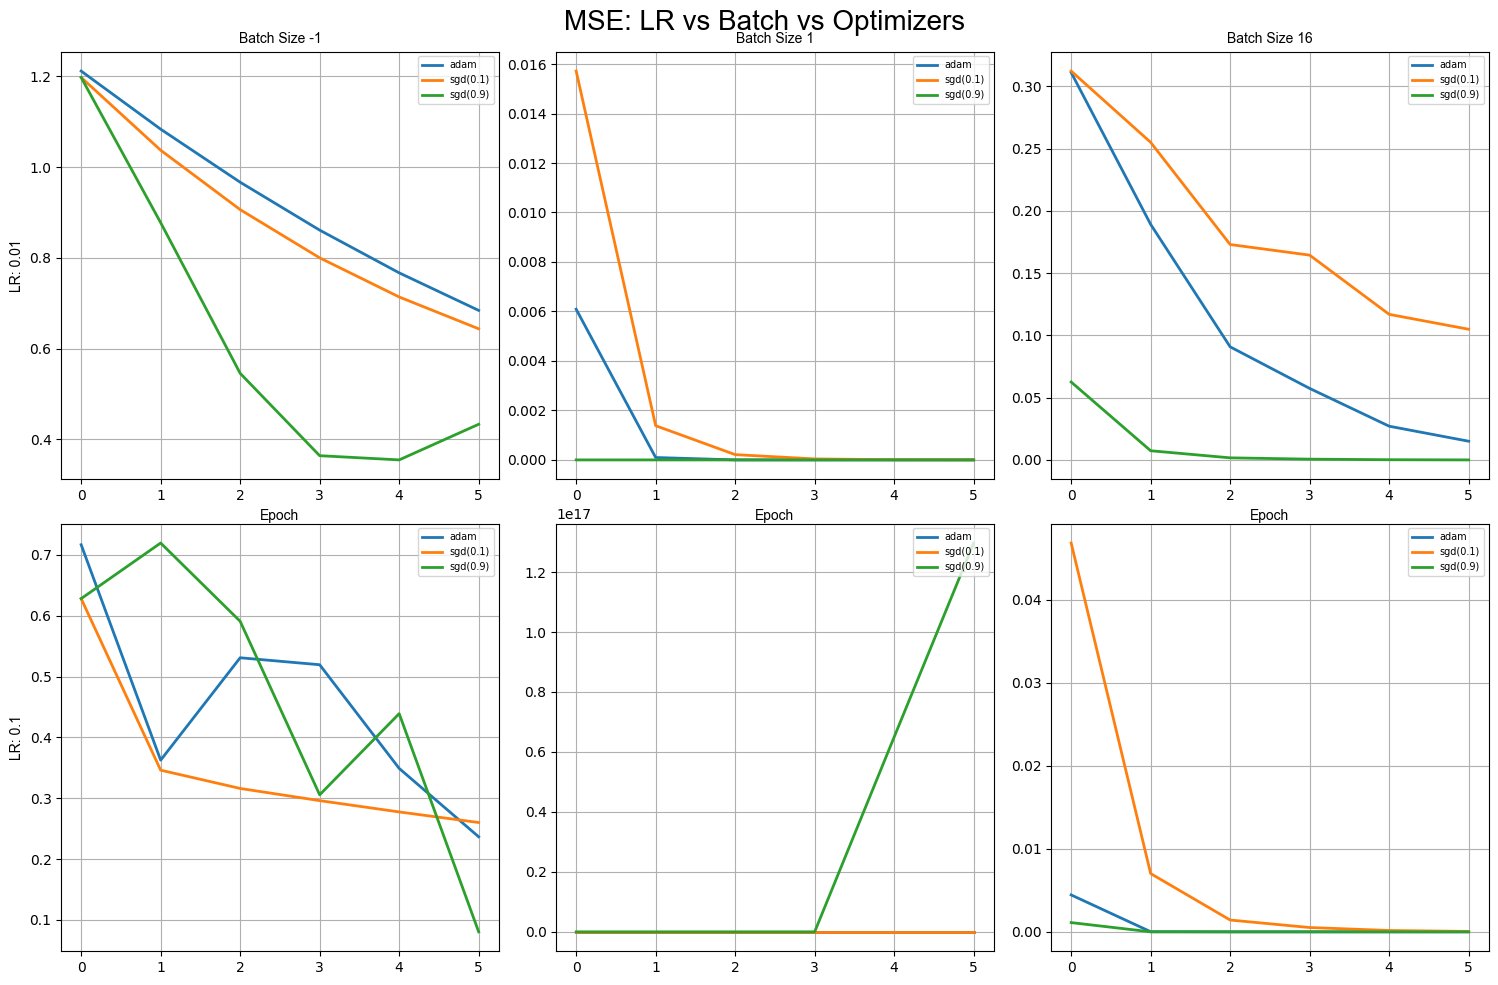

['mean_absolute_error', 'mean_squared_error'] [-1, 1, 16] ['adam', 'sgd']
Adding Exp_100_mean_absolute_error_6_-1_adam_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_-1_adam_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_-1_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_-1_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_absolute_error_6_-1_sgd_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_-1_sgd_0.1_0.9 to plots.
Adding Exp_100_mean_absolute_error_6_1_adam_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_1_adam_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_1_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_1_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_absolute_error_6_1_sgd_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_1_sgd_0.1_0.9 to plots.
Adding Exp_100_mean_absolute_error_6_16_adam_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_16_adam_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_16_sgd_0.01_0.

<Figure size 640x480 with 0 Axes>

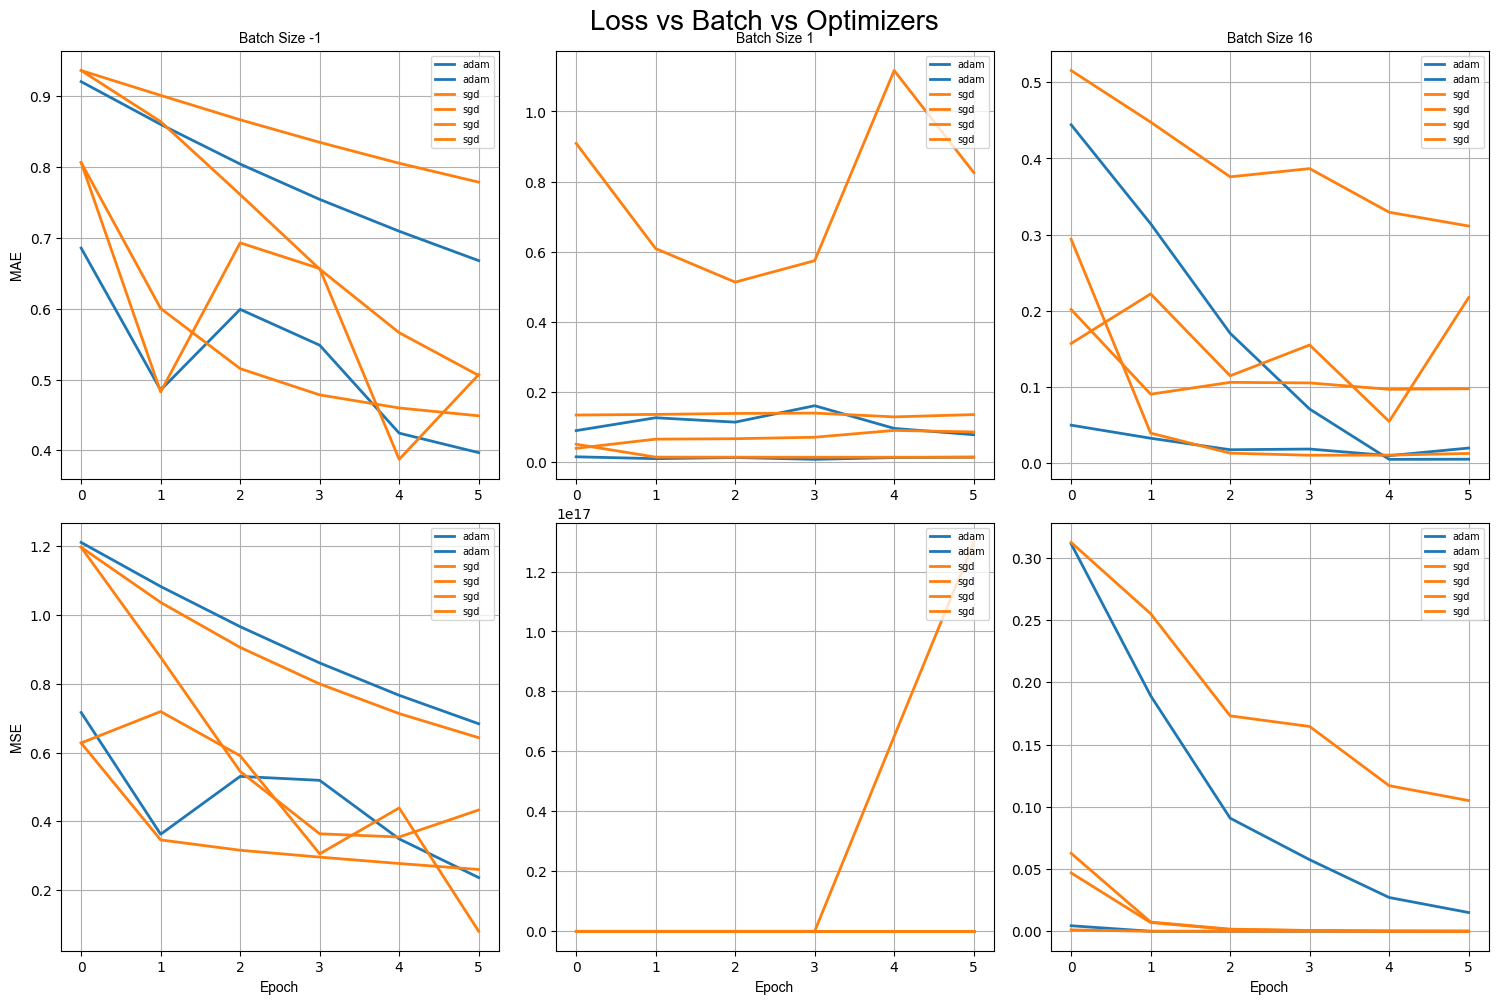

Best model for LossType.MSE with batch size 16 and optimizer adam: Exp_100_mean_squared_error_6_1_adam_0.01_0.1 with loss 0.0010312816948827555.
Worst model for LossType.MSE with batch size 16 and optimizer adam: Exp_100_mean_squared_error_6_-1_adam_0.01_0.1 with loss 0.9289105435212454.
Best model for LossType.MSE with batch size 16 and optimizer sgd: Exp_100_mean_squared_error_6_1_sgd_0.01_0.9 with loss 7.015302482445603e-10.
Worst model for LossType.MSE with batch size 16 and optimizer sgd: Exp_100_mean_squared_error_6_-1_sgd_0.01_0.1 with loss 0.8830029666423798.
Making figure with 2 rows and 2 columns.


<Figure size 640x480 with 0 Axes>

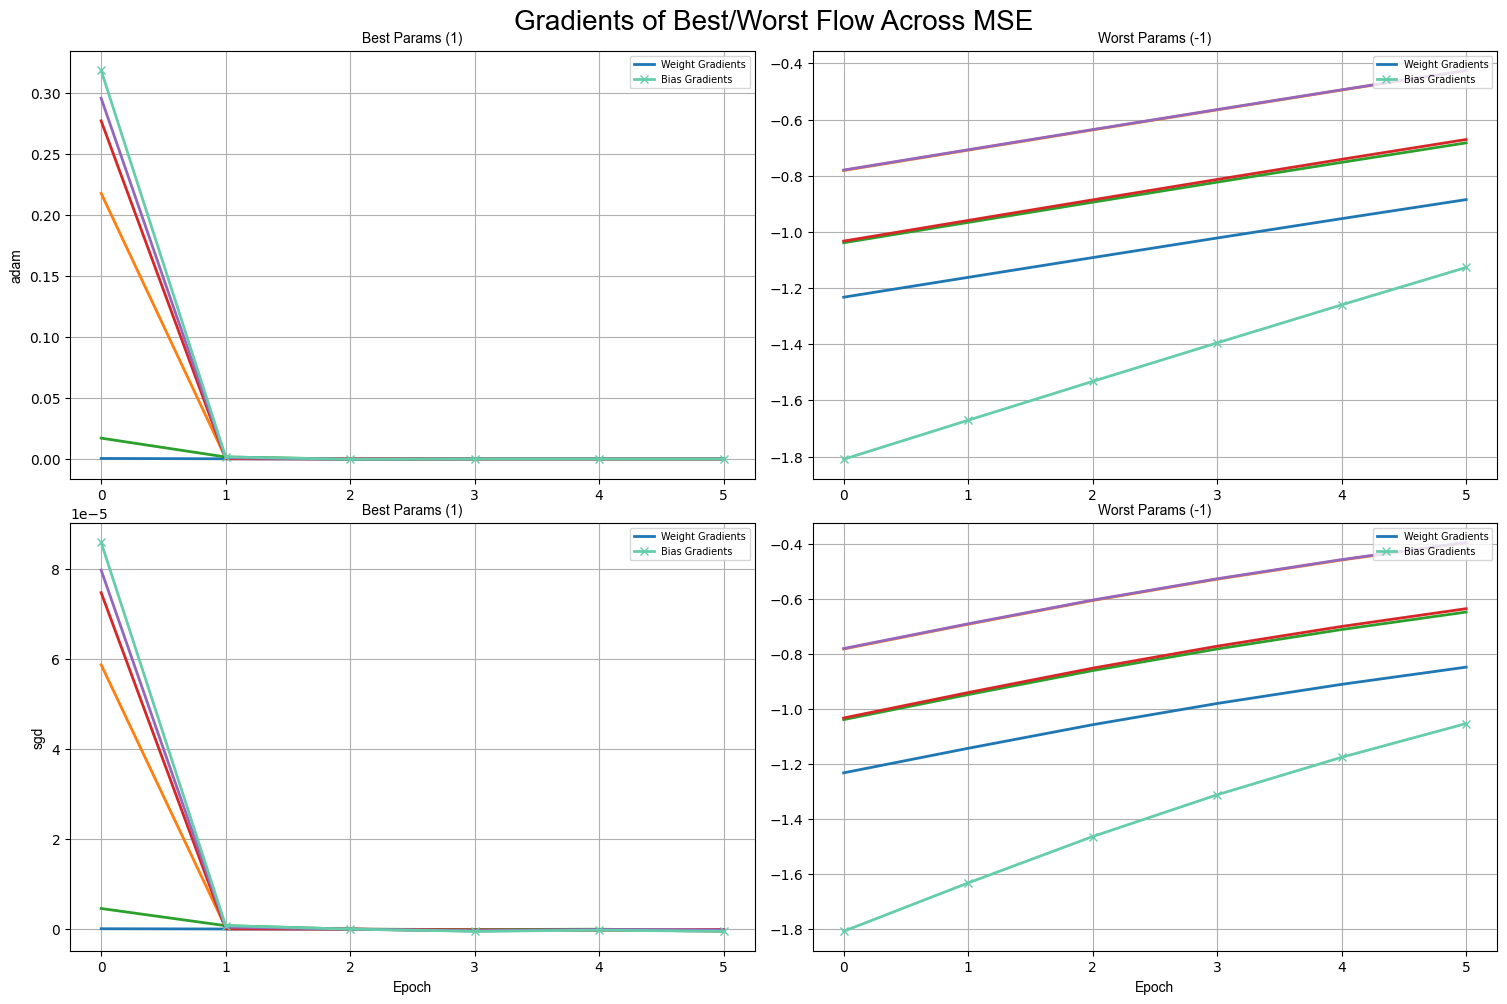

Making figure with 2 rows and 3 columns.


<Figure size 640x480 with 0 Axes>

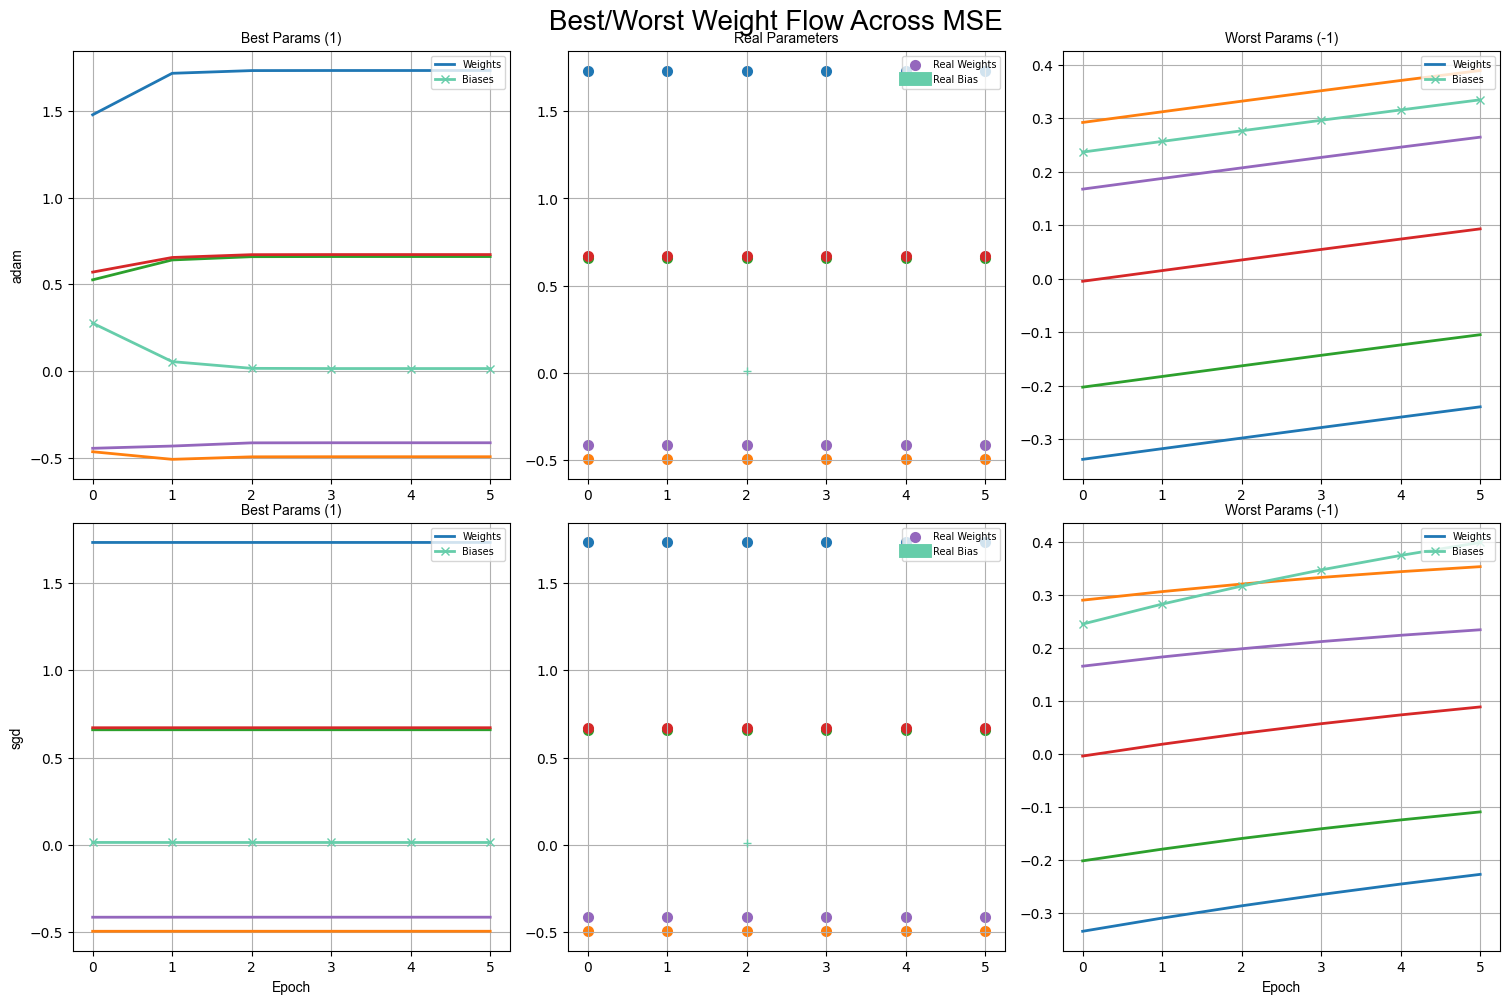

In [19]:
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title=f"MSE: LR vs Batch vs Optimizers",
                                 use_tex=False))

viz.clear_plots()
plots = expt_handler.make_lr_plots()
for plot in plots:
    viz.append_plot(plot)

viz.generate_plots()
plt.show()

viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title=f"Loss vs Batch vs Optimizers",
                                 use_tex=False))
viz.clear_plots()
plots = expt_handler.make_loss_plots()
for plot in plots:
    viz.append_plot(plot)

viz.generate_plots()
plt.show()

selected_loss = LossType.MSE
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title=f"Gradients of Best/Worst Flow Across {selected_loss.name}",
                                 use_tex=False))
viz.clear_plots()
plots, grad_plots = expt_handler.plot_best_and_worst_weight_flow(plot_type=PlotType.LINE, selected_loss=selected_loss)
for plot in grad_plots:
    viz.append_plot(plot)

viz.generate_plots()
plt.show()

viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title=f"Best/Worst Weight Flow Across {selected_loss.name}",
                                 use_tex=False))
viz.clear_plots()
for plot in plots:
    viz.append_plot(plot)

viz.generate_plots()
plt.show()

### LR Based Plots

['mean_squared_error'] [-1, 1, 16] ['adam', 'sgd'] [0.01, 0.1] [0.1, 0.9]
Adding Exp_100_mean_squared_error_6_-1_adam_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_-1_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_-1_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_squared_error_6_1_adam_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_1_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_1_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_squared_error_6_16_adam_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_16_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_squared_error_6_16_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_squared_error_6_-1_adam_0.1_0.1 to plots.
Adding Exp_100_mean_squared_error_6_-1_sgd_0.1_0.1 to plots.
Adding Exp_100_mean_squared_error_6_-1_sgd_0.1_0.9 to plots.
Adding Exp_100_mean_squared_error_6_1_adam_0.1_0.1 to plots.
Adding Exp_100_mean_squared_error_6_1_sgd_0.1_0.1 to plots.
Adding Exp_100_mean_squared_error_6_1_sgd_0.1_0.9 to plots.
Add

(<Figure size 1500x1000 with 6 Axes>,
 array([[<Axes: title={'center': 'Batch Size -1'}, ylabel='LR: 0.01'>,
         <Axes: title={'center': 'Batch Size 1'}>,
         <Axes: title={'center': 'Batch Size 16'}>],
        [<Axes: xlabel='Epoch', ylabel='LR: 0.1'>, <Axes: xlabel='Epoch'>,
         <Axes: xlabel='Epoch'>]], dtype=object))

<Figure size 640x480 with 0 Axes>

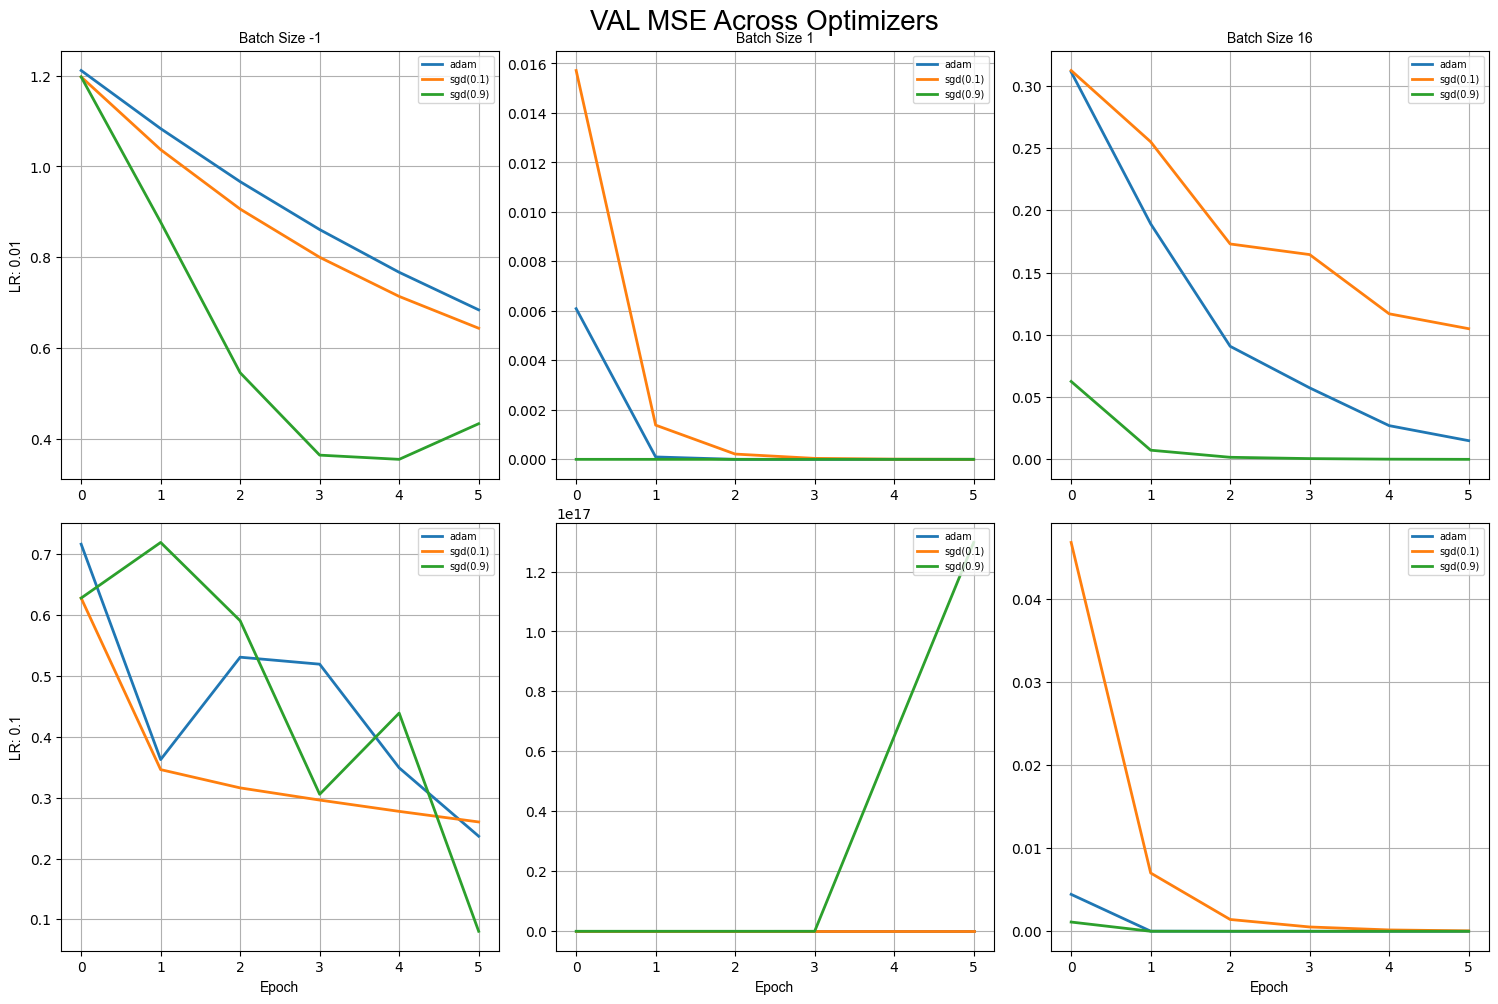

In [10]:
def make_lr_plots(self, loss:LossType = LossType.MSE)->List[Plot]:
        keys = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values() if expt.config.loss==loss])
        opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        learning_rates = set([expt.config.learning_rate for expt in self.experiments.values()])
        momentums = set([expt.config.momentum for expt in self.experiments.values()])

        learning_rates = sorted(learning_rates)
        momentums = sorted(momentums)
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)

        print(losses, batch_sizes, opt_names, learning_rates, momentums)
        
        new_row = False
        new_col = False
        plots = []
        completed_expts = []


        for l, lr in enumerate(learning_rates):
            for b, bs in enumerate(batch_sizes):
                cindex = 0
                for o, opt_name in enumerate(opt_names):
                    for mi,m in enumerate(momentums):
                        if mi>0 and opt_name != Optimizer.SGD.value:
                            continue
                        for expt_name, expt in self.experiments.items():
                            if expt.config.batch_size == bs and expt.config.loss == loss and expt.config.optimizer.value == opt_name and expt.config.learning_rate == lr and expt.config.momentum == m and expt_name not in completed_expts:
                                
                                print(f"Adding {expt_name} to plots.")

                                val_metric = np.array([m["val_loss"] for m in expt.losses.values()])
                                ylabel = f"lr: {lr}"

                                if b==0:
                                    ylabel=ylabel.upper()
                                else:
                                    ylabel=""

                                if l==0:
                                    title=f'Batch Size {bs}'
                                else:
                                    title=""
                                
                                if l==len(learning_rates)-1:
                                    xlabel="Epoch"
                                else:
                                    xlabel=''

                                if new_row:
                                    order = PlotOn.APPEND_DOWN
                                    new_col=False
                                    new_row=False

                                elif new_col:
                                    order = PlotOn.APPEND_RIGHT
                                    new_col=False
                                    new_row=False
                                else:
                                    order = PlotOn.RIGHT
                                    new_col=False
                                    new_row=False
                                    
                                # row.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=order, title=f'Train {loss}',legend=f"{opt_name}", color=keys[i]))
                                legend = f"{opt_name}" if opt_name != Optimizer.SGD.value else f"{opt_name}({m})"
                                plots.append(Plot(X=np.arange(len(val_metric)), title_size=10, y=val_metric, plot_type=PlotType.LINE, plot_order=order, ylabel=ylabel, xlabel=xlabel, title=title,legend=legend, color=keys[o+mi]))
                                # i+=1
                                completed_expts.append(expt_name)
                                
                new_col = True
            new_row = True
                    
        return plots


expt_handler.make_lr_plots=make_lr_plots.__get__(expt_handler, ExperimentHandler)
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title="VAL MSE Across Optimizers",
                                 use_tex=False))
viz.clear_plots()
plots = expt_handler.make_lr_plots()
for plot in plots:
    viz.append_plot(plot)

viz.generate_plots()

### Loss Plots

['mean_absolute_error', 'mean_squared_error'] [-1, 1, 16] ['adam', 'sgd']
Adding Exp_100_mean_absolute_error_6_-1_adam_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_-1_adam_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_-1_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_-1_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_absolute_error_6_-1_sgd_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_-1_sgd_0.1_0.9 to plots.
Adding Exp_100_mean_absolute_error_6_1_adam_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_1_adam_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_1_sgd_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_1_sgd_0.01_0.9 to plots.
Adding Exp_100_mean_absolute_error_6_1_sgd_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_1_sgd_0.1_0.9 to plots.
Adding Exp_100_mean_absolute_error_6_16_adam_0.01_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_16_adam_0.1_0.1 to plots.
Adding Exp_100_mean_absolute_error_6_16_sgd_0.01_0.

(<Figure size 1500x1000 with 6 Axes>,
 array([[<Axes: title={'center': 'Batch Size -1'}, ylabel='MAE'>,
         <Axes: title={'center': 'Batch Size 1'}>,
         <Axes: title={'center': 'Batch Size 16'}>],
        [<Axes: xlabel='Epoch', ylabel='MSE'>, <Axes: xlabel='Epoch'>,
         <Axes: xlabel='Epoch'>]], dtype=object))

<Figure size 640x480 with 0 Axes>

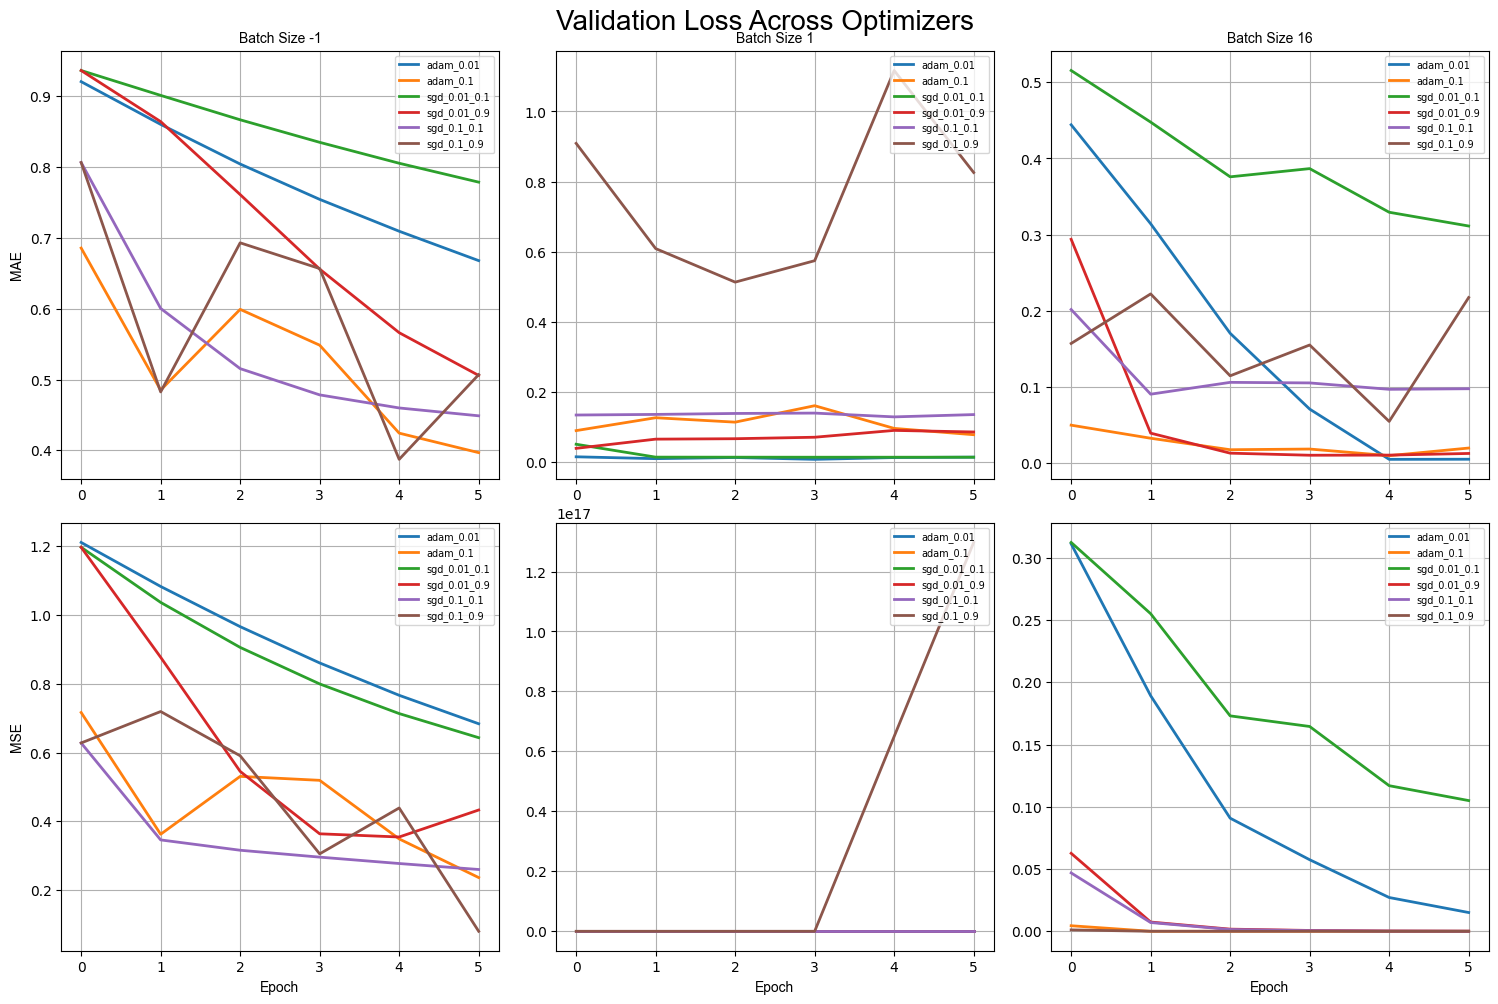

In [26]:
def make_loss_plots(self, metric:str='val_loss', learning_rate:float=0.01)->List[Plot]:
        keys = list(visible_colors.values())
        batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
        losses = set([expt.config.loss.value for expt in self.experiments.values()])
        opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
        learning_rates = set([expt.config.learning_rate for expt in self.experiments.values()])
        momentums = set([expt.config.momentum for expt in self. experiments.values()])
        
        batch_sizes=sorted(batch_sizes)
        opt_names = sorted(opt_names)
        losses = sorted(losses)
        learning_rates = sorted(learning_rates)
        momentums = sorted(momentums)

        print(losses, batch_sizes, opt_names)
        
        new_row = False
        new_col = False
        plots = []
        completed_expts = []
        
        for l, loss in enumerate(losses):
            for b, bs in enumerate(batch_sizes):
                ind=0
                for o,opt_name in enumerate(opt_names):
                    for expt_name, expt in self.experiments.items():
                        for lr,learning_rate in enumerate(learning_rates):
                            for mi,momentum in enumerate(momentums):
                                if expt.config.batch_size == bs and expt.config.loss.value == loss and expt.config.optimizer.value == opt_name and expt_name not in completed_expts and expt.config.momentum == momentum and \
                                    expt.config.learning_rate==learning_rate:
                                    print(f"Adding {expt_name} to plots.")

                                    val_metric = np.array([m[metric] for m in expt.losses.values()])
                                    ylabel = "".join([l[0] for l in loss.split("_")])

                                    if b==0:
                                        ylabel=ylabel.upper()
                                    else:
                                        ylabel=""

                                    if l==0:
                                        title=f'Batch Size {bs}'
                                    else:
                                        title=""
                                    
                                    if l==len(losses)-1:
                                        xlabel="Epoch"
                                    else:
                                        xlabel=''

                                    if new_row:
                                        order = PlotOn.APPEND_DOWN
                                        new_col=False
                                        new_row=False

                                    elif new_col:
                                        order = PlotOn.APPEND_RIGHT
                                        new_col=False
                                        new_row=False
                                    else:
                                        order = PlotOn.RIGHT
                                        new_col=False
                                        new_row=False
                                        
                                    # row.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=order, title=f'Train {loss}',legend=f"{opt_name}", color=keys[i]))
                                    legend = f"{opt_name}_{learning_rate}_{momentum}" if opt_name==Optimizer.SGD.value else f"{opt_name}_{learning_rate}"
                                    plots.append(Plot(X=np.arange(len(val_metric)), title_size=10, y=val_metric, plot_type=PlotType.LINE, plot_order=order, ylabel=ylabel, xlabel=xlabel, title=title,legend=legend, color=keys[ind]))
                                    ind+=1
                                    # i+=1
                                    completed_expts.append(expt_name)
                            
                new_col = True
            new_row = True
        
        # only show title for first row of plots
            
        return plots


expt_handler.make_loss_plots=make_loss_plots.__get__(expt_handler, ExperimentHandler)
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title="Validation Loss Across Optimizers",
                                 use_tex=False))
viz.clear_plots()
plots = expt_handler.make_loss_plots()
for plot in plots:
    viz.append_plot(plot)

viz.generate_plots()

### Best Worst Weight Flow

Best model for LossType.MSE with batch size 16 and optimizer adam: Exp_100_mean_squared_error_6_1_adam_0.01_0.1 with loss 0.0010312816948827555.
Worst model for LossType.MSE with batch size 16 and optimizer adam: Exp_100_mean_squared_error_6_-1_adam_0.01_0.1 with loss 0.9289105435212454.
Best model for LossType.MSE with batch size 16 and optimizer sgd: Exp_100_mean_squared_error_6_1_sgd_0.01_0.9 with loss 7.015302482445603e-10.
Worst model for LossType.MSE with batch size 16 and optimizer sgd: Exp_100_mean_squared_error_6_-1_sgd_0.01_0.1 with loss 0.8830029666423798.
Making figure with 2 rows and 2 columns.


(<Figure size 1500x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Best Params (1)'}, ylabel='adam'>,
         <Axes: title={'center': 'Worst Params (-1)'}>],
        [<Axes: title={'center': 'Best Params (1)'}, xlabel='Epoch', ylabel='sgd'>,
         <Axes: title={'center': 'Worst Params (-1)'}, xlabel='Epoch'>]],
       dtype=object))

<Figure size 640x480 with 0 Axes>

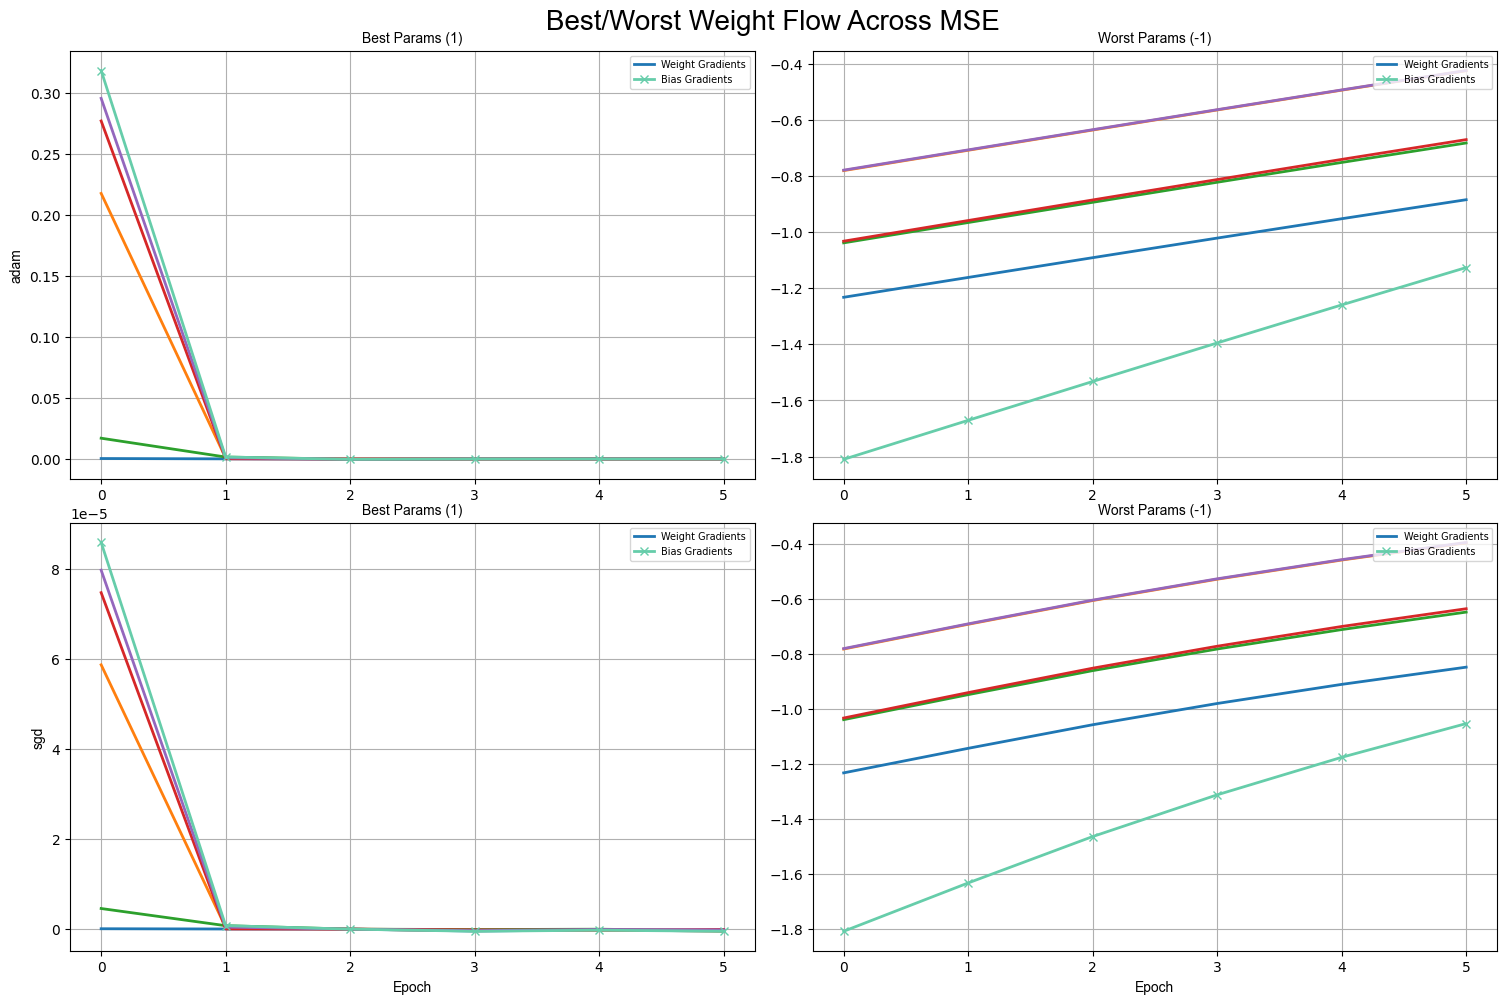

In [18]:
def plot_best_and_worst_weight_flow(self, selected_loss:LossType=LossType.MSE, plot_type:PlotType=PlotType.SCATTER, learning_rate:float=0.01)->List[Plot]:
    colors = list(visible_colors.values())
    batch_sizes = set([expt.config.batch_size for expt in self.experiments.values()])
    losses = set([expt.config.loss.value for expt in self.experiments.values() if expt.config.loss == selected_loss])
    opt_names = set([expt.config.optimizer.value for expt in self.experiments.values()])
    batch_sizes=sorted(batch_sizes)
    opt_names = sorted(opt_names)
    losses = sorted(losses)

    
    plots = []
    grad_plots = []

    
    # loop across all combinations and find best model for each loss function

    po = -1
    for o, opt_name in enumerate(opt_names):
        best_expt = None
        best_loss = np.inf
        worst_expt = None
        worst_loss = -np.inf

        
        best_weights_plots = []
        worst_weights_plots = []

        best_gradients_plots = []
        worst_gradients_plots = []

        bs=0
        expt_name = None
        
        
        for l,loss in enumerate(losses):
            for b, bs in enumerate(batch_sizes):
                for expt_name, expt in self.experiments.items():
                    if expt.config.batch_size == bs and expt.config.loss.value == loss and expt.config.optimizer.value == opt_name and expt.config.learning_rate==learning_rate:
                        val_loss = np.array([m["val_loss"] for m in expt.losses.values()]).mean()
                        if val_loss < best_loss:
                            best_loss = val_loss
                            best_expt = expt_name
                        if val_loss > worst_loss:
                            worst_loss = val_loss
                            worst_expt = expt_name
        
        if expt_name is None:
            continue

        print(f"Best model for {selected_loss} with batch size {bs} and optimizer {opt_name}: {best_expt} with loss {best_loss}.")
        print(f"Worst model for {selected_loss} with batch size {bs} and optimizer {opt_name}: {worst_expt} with loss {worst_loss}.")

        
        best_expt = self.experiments[best_expt]
        worst_expt = self.experiments[worst_expt]
        epochs = np.array(best_expt.train_runner.logs['epochs'])
        best_weights = np.array(best_expt.train_runner.logs['weights']).reshape(len(epochs), -1)
        best_biases = np.array(best_expt.train_runner.logs['biases']).reshape(len(epochs), -1)
        best_weight_gradients = np.array(best_expt.train_runner.logs['weight_gradients']).reshape(len(epochs), -1)
        best_bias_gradients = np.array(best_expt.train_runner.logs['bias_gradients']).reshape(len(epochs), -1)

        
        worst_weights = np.array(worst_expt.train_runner.logs['weights']).reshape(len(epochs), -1)
        worst_biases = np.array(worst_expt.train_runner.logs['biases']).reshape(len(epochs), -1)
        worst_weight_gradients = np.array(worst_expt.train_runner.logs['weight_gradients']).reshape(len(epochs), -1)
        worst_bias_gradients = np.array(worst_expt.train_runner.logs['bias_gradients']).reshape(len(epochs), -1)
        
        real_weights = best_expt.real_weights
        real_biases = best_expt.real_biases
        real_weights_plots = []

        for widx in range(best_weights.shape[1]):
            best_weight = best_weights[:, widx].flatten()
            best_gradient = best_weight_gradients[:, widx].flatten()
            worst_weight = worst_weights[:, widx].flatten()
            worst_gradient = worst_weight_gradients[:, widx].flatten()
            color = colors[len(colors)%(widx+1)]
            
            best_weights_plots.append(Plot(X=epochs, y=best_weight, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))
            worst_weights_plots.append(Plot(X=epochs, y=worst_weight, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))
            real_weights_plots.append(Plot(X=epochs, y=real_weights[widx]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT,
                                    color=color, allow_animation=False))
            
            best_gradients_plots.append(Plot(X=epochs, y=best_gradient, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))
            worst_gradients_plots.append(Plot(X=epochs, y=worst_gradient, plot_type=plot_type, plot_order=PlotOn.RIGHT, color=color))


        
        bc=colors[len(colors)-1]
        best_weights_plots.extend([Plot(X=epochs, y=[b.flatten() for b in best_biases], plot_type=plot_type, plot_order=PlotOn.RIGHT, title_size=10, title=f'Best Params ({best_expt.config.batch_size})',
                                color=bc, marker='x'),
                             ])
        worst_weights_plots.extend([Plot(X=epochs, y=[b.flatten() for b in worst_biases], plot_type=plot_type, plot_order=PlotOn.RIGHT,title_size=10, title=f'Worst Params ({worst_expt.config.batch_size})',
                                color=bc, marker='x'),
                             ])
        best_gradients_plots.extend([Plot(X=epochs, y=[bg.flatten() for bg in best_bias_gradients], plot_type=plot_type, plot_order=PlotOn.RIGHT, title_size=10, title=f'Best Params ({best_expt.config.batch_size})',legend='Bias Gradients',
                                color=bc, marker='x'),
                             ])
        worst_gradients_plots.extend([Plot(X=epochs, y=[bg.flatten() for bg in worst_bias_gradients], plot_type=plot_type, plot_order=PlotOn.RIGHT,title_size=10, title=f'Worst Params ({worst_expt.config.batch_size})', legend='Bias Gradients',
                                color=bc, marker='x'),
                             ])
        
        best_weights_plots[-1].legend = 'Biases'
        best_weights_plots[0].legend = 'Weights'
        
        worst_weights_plots[-1].legend = 'Biases'
        worst_weights_plots[0].legend = 'Weights'

        best_gradients_plots[0].legend = 'Weight Gradients'
        worst_gradients_plots[0].legend = 'Weight Gradients'


        real_weights_plots[-1].legend='Real Weights'
        
        real_weights_plots[0].plot_order=PlotOn.APPEND_RIGHT
        real_weights_plots.append(Plot(X=np.array([int(len(real_weights)//2)]), y=np.array([real_biases[0]]), plot_type=plot_type, plot_order=PlotOn.RIGHT, legend='Real Bias', linewidth=10, title_size=10,
                                 marker='+', color=colors[len(colors)-1], allow_animation=False))
        

        worst_weights_plots[0].plot_order=PlotOn.APPEND_RIGHT
        worst_gradients_plots[0].plot_order=PlotOn.APPEND_RIGHT
        
        
        if po!=o:
            best_weights_plots[0].plot_order=PlotOn.APPEND_DOWN
            best_weights_plots[-1].ylabel=opt_name
            best_gradients_plots[0].plot_order=PlotOn.APPEND_DOWN
            best_gradients_plots[-1].ylabel=opt_name
        if o==0:
            # worst_weights_plots[-1].title='Worst Parameters'
            # best_weights_plots[-1].title='Best Parameters'
            real_weights_plots[-1].title='Real Parameters'
        if o==len(opt_names)-1:
            worst_weights_plots[-1].xlabel='Epoch'
            best_weights_plots[-1].xlabel='Epoch'
            best_gradients_plots[-1].xlabel='Epoch'
            worst_gradients_plots[-1].xlabel='Epoch'

            # real_weights_plots[0].xlabel='Epoch'
        
        grad_plots.extend(best_gradients_plots)
        grad_plots.extend(worst_gradients_plots)

        plots.extend(best_weights_plots)
        plots.extend(real_weights_plots)
        plots.extend(worst_weights_plots)
        po=o
        


    return plots, grad_plots

expt_handler.plot_best_and_worst_weight_flow=plot_best_and_worst_weight_flow.__get__(expt_handler, ExperimentHandler)
selected_loss = LossType.MSE
viz = MatplotlibVisualizer(config=MatplotlibVizConfig(figsize=(15,10),title=f"Best/Worst Weight Flow Across {selected_loss.name}",
                                 use_tex=False))
viz.clear_plots()
plots, grad_plots = expt_handler.plot_best_and_worst_weight_flow(plot_type=PlotType.LINE, selected_loss=selected_loss)
for plot in grad_plots:
    viz.append_plot(plot)

viz.generate_plots()